In [8]:
import numpy as np
import math
np.set_printoptions(precision=4, suppress=True, linewidth=10000)
import matplotlib.pyplot as plt
import pandas as pd


In [9]:
#definitions

extinction_status = 0
warning = 0
sex = 0


#one less coz alleles are recorded without sex

In [10]:
class parameters:
    def __init__(self):
        # Primary parameters
        self.popsize = 2000
        self.d = [0.2, 0.2]
        self.v = 10
        self.C = 2
        self.L = float('inf')
        self.mut = 0.01
        self.mutsize = 0.1
        self.initmean = [0, 0, 0]
        self.shared = False
        self.generations = 10001

        # Secondary parameters
        self.v /= (self.popsize / 2)  # Adjust v for population size
       
        self.maledeathrate = self.d[0]
        self.femaledeathrate = self.d[1]

        parameters.sa = np.array([0,1])
        parameters.ma = np.array([2,3])
        parameters.fa = np.array([4,5])

        if self.shared:
            self.mel = np.concatenate((self.sa, self.ma))
            self.fel = np.concatenate((self.sa, self.fa))
        else:
            self.mel = parameters.ma
            self.fel = parameters.fa

        # Run one mating season
       

In [11]:
class Individual:
    def __init__(self, parameters_instance):

        self.parameters_instance = parameters_instance
        self.index = None
        self.sex = np.random.choice([-1, 1])
        self.alleles = None
        self.emergencetime = None
        self.deathtime = None
        
        self.total_genotype = None
        self.emergence_phenotype = None
    

        #if female
        self.mate_identity = None
        self.mating_time = None

        #if male
        self.matecount = 0

        #define emergence phenotype as an averge of the alleles
    
    def initialise_alleles_emergence_and_deathtime(self):
            self.alleles = np.random.normal(0, 1, size=(6, ))
            self.alleles[self.parameters_instance.sa[0]] += self.parameters_instance.initmean[0]
            self.alleles[self.parameters_instance.sa[1]] += self.parameters_instance.initmean[0]

            self.alleles[self.parameters_instance.ma[0]] += self.parameters_instance.initmean[1]
            self.alleles[self.parameters_instance.ma[1]] += self.parameters_instance.initmean[1]

            self.alleles[self.parameters_instance.fa[0]] += self.parameters_instance.initmean[2]
            self.alleles[self.parameters_instance.fa[1]] += self.parameters_instance.initmean[2]


            self.emergence_phenotype_function()
            self.emergence_sample_function()
            self.deathtime_function()


    def emergence_phenotype_function(self):

        if self.sex == 1:
            fel_alleles = [self.alleles[i] for i in self.parameters_instance.fel]
            self.emergence_phenotype = np.mean(fel_alleles)
    
        if self.sex == -1:
            mel_alleles = [self.alleles[i] for i in self.parameters_instance.mel]
            self.emergence_phenotype = np.mean(mel_alleles)
            

    def emergence_sample_function(self):
        p = np.random.rand()
        sample =  self.emergence_phenotype + np.log(p / (1 - p))
        self.emergencetime = sample

        
    def deathtime_function(self):
        if self.sex == 1:
            self.deathtime =  self.emergencetime  + np.random.exponential(1 / self.parameters_instance.femaledeathrate)
        if self.sex == -1:
            self.deathtime =  self.emergencetime  + np.random.exponential(1 / self.parameters_instance.maledeathrate)

    def fecundity_function(self):

        if self.sex == 1 and self.mate_identity != None:
        
            self.fecundity = 400 * np.exp(self.mating_time / self.parameters_instance.L) / (1 + np.exp(self.mating_time / self.parameters_instance.L))**2
    
        else:
            self.fecundity = 0

        return self.fecundity
    


    def offspring_inherit_alleles(self):

        self.offspring = Individual(self.parameters_instance)

        inherited_allele_1 = np.random.choice([self.alleles[0], self.mate_identity.alleles[0]]) 
        inherited_allele_2 = np.random.choice([self.alleles[1], self.mate_identity.alleles[1]])
        inherited_allele_3 = np.random.choice([self.alleles[2], self.mate_identity.alleles[2]])
        inherited_allele_4 = np.random.choice([self.alleles[3], self.mate_identity.alleles[3]])
        inherited_allele_5 = np.random.choice([self.alleles[4], self.mate_identity.alleles[4]])
        inherited_allele_6 = np.random.choice([self.alleles[5], self.mate_identity.alleles[5]])

        self.offspring.alleles = [inherited_allele_1, inherited_allele_2, inherited_allele_3, inherited_allele_4, inherited_allele_5, inherited_allele_6]
    
    def mutate_allele_of_offspring(self):
            
            for i in range(6):

                if np.random.rand() < self.parameters_instance.mut:

                    mutation = self.parameters_instance.mutsize*np.random.normal(0,1)
                    self.offspring.alleles[i] += mutation

    def produce_offspring(self):
        self.offspring_inherit_alleles()
        self.mutate_allele_of_offspring()

        self.offspring.emergence_phenotype_function()
        self.offspring.emergence_sample_function()
        self.offspring.deathtime_function()


        return self.offspring


    def __repr__(self):

        repr2 = f"sex: {self.sex}, alleles: {np.round(self.alleles, 2)[0]}"
        repr1 = f"sex: {self.sex}, emergencetime: {round(self.emergencetime,1)}, deathtime: {round(self.deathtime,1)}"
        repr3 = f"ind"
        repr4 = f"sex: {self.sex}, matecount: {self.matecount},identity_of_males: {self.mate_identity} ,time_of_mating: {self.mating_time}"

        repr_sex_and_emeregence_phenotype = f"sex: {self.sex}, alleles: {np.round(self.emergence_phenotype, 2)}"


        return repr_sex_and_emeregence_phenotype
        



In [12]:
class data_collection_and_plotting:

    def __init__(self, parameters_instance):
        self.t_for_axis = np.arange(0, parameters_instance.generations, 10)
        self.shape = (int((parameters_instance.generations - 1) / 10 + 1), 4)
        self.data = np.full(self.shape, np.nan)
    

    def calculate_mean_fecundity(self, list_of_individuals):
        mated_females = [individual for individual in list_of_individuals if individual.sex == 1 and individual.matecount > 0]
        fecundity_list_for_calculation = [female.fecundity for female in mated_females]
        self.mean_fecundity = sum(fecundity_list_for_calculation) / len(fecundity_list_for_calculation) if len(fecundity_list_for_calculation) > 0 else 0


    def calculate_mean_mel_alleles(self, list_of_individuals):
        mel_alleles_of_pop = [individual.emergence_phenotype for individual in list_of_individuals if individual.sex == -1]
        self.average_population_mel_alleles = np.mean(mel_alleles_of_pop)

    def calculate_mean_fel_alleles(self, list_of_individuals):
        fel_alleles_of_pop= [individual.emergence_phenotype for individual in list_of_individuals if individual.sex == 1]
        self.average_population_fel_alleles = np.mean(fel_alleles_of_pop)


    def calculate_matelesss_females_fraction(self, list_of_individuals):
        total_females = sum(1 for individual in list_of_individuals if individual.sex == 1)
        unmated_females = sum(1 for individual in list_of_individuals if individual.sex == 1 and individual.matecount == 0)
        self.fraction_unmated = (unmated_females / total_females)
    

    def data_collection_function(self, list_of_individuals, generation_number):
        self.calculate_mean_fecundity(list_of_individuals)
        self.calculate_mean_mel_alleles(list_of_individuals)
        self.calculate_mean_fel_alleles(list_of_individuals)
        self.calculate_matelesss_females_fraction(list_of_individuals)


        self.data[int((generation_number-1)/10), :] = [self.average_population_mel_alleles, self.average_population_fel_alleles, self.mean_fecundity, self.fraction_unmated]

    def plot_data(self, generation_number):

        plt.figure(1)

        plt.subplot(3, 1, 1)
        plt.plot(self.t_for_axis, self.data[:, 0], 'b', self.t_for_axis, self.data[:, 1], 'r')
        plt.ylabel('Timing')
        plt.subplot(3, 1, 2)
        plt.plot(self.t_for_axis, self.data[:, 2], 'g')
        plt.ylabel('fecundity')
        plt.subplot(3, 1, 3)
        plt.plot(self.t_for_axis, self.data[:, 3], 'k')
        plt.ylabel('matelessness')

        plt.tight_layout()  # Adjust subplot parameters to give specified padding
        plt.show() 

        print("generation", generation_number)

    


In [13]:
class one_generation_simulation():
    def __init__(self, parameters_instance):
        self.parameters_instance = parameters_instance        


    def run_simulation_for_one_generation(self, list_of_individuals):
    
        list_of_individuals_after_mating = self.population_mating_algorithm(list_of_individuals)
        list_of_offspring = self.make_list_of_offspring_after_mating(list_of_individuals_after_mating)

        return list_of_offspring


    def population_mating_algorithm(self, list_of_individuals):

        sorted_encounter_list = self.potential_encounter_times(list_of_individuals)
        self.matings_and_matecount_update(sorted_encounter_list)

        return list_of_individuals
    
    def potential_encounter_times(self, list_of_individuals):
        
        encounter_times = []
        for female in list_of_individuals:
            if female.sex == 1:
                for male in list_of_individuals:
                    if male.sex == -1:
                        encounter_time = max(male.emergencetime, female.emergencetime) + np.random.exponential(1/self.parameters_instance.v)
                        if (encounter_time < male.deathtime and encounter_time < female.deathtime):
                            encounter_times.append([encounter_time, male, female])

        sorted_encounter_list = sorted(encounter_times, key=lambda x: x[0])
        return sorted_encounter_list
    

    def matings_and_matecount_update(self, sorted_encounter_list):

        mated_males_emergence_time = []
        mated_females_emergence_time = []

        for encounter_time, male, female in sorted_encounter_list:
            if male.matecount < self.parameters_instance.C and female.matecount < 1:
                male.matecount += 1
                
                female.matecount += 1
                female.mate_identity = male
                female.mating_time = encounter_time

                mated_males_emergence_time.append(male.emergence_phenotype)
                mated_females_emergence_time.append(female.emergence_phenotype)

        return sorted_encounter_list
        
    def make_list_of_offspring_after_mating(self,list_of_individuals):
    
        fecundity_probability_list = self.make_fecundity_probabilty_list_from_mated_individuals(list_of_individuals)
        offspring_list = self.from_relative_fecundity_to_offspring(fecundity_probability_list, list_of_individuals)

        return offspring_list
    
    def make_fecundity_probabilty_list_from_mated_individuals(self,list_of_individuals):
        fecundity_list = []
        for individual in list_of_individuals:
            fecundity_of_individual = individual.fecundity_function()
            fecundity_list.append(fecundity_of_individual)

        if sum(fecundity_list) == 0:
            print("extinction")

        else: 

            fecundity_probability = [x / sum(fecundity_list) for x in fecundity_list]
        
        return fecundity_probability


    def from_relative_fecundity_to_offspring(self, fecundity_probabiilty, list_of_individuals):
        
        mother_list = np.random.choice(self.parameters_instance.popsize, self.parameters_instance.popsize, p=fecundity_probabiilty, replace=True)
        offspring_list = [list_of_individuals[mother_index].produce_offspring() for mother_index in mother_list]


        return offspring_list



[[  0.058   -0.003  100.       0.1017]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
0


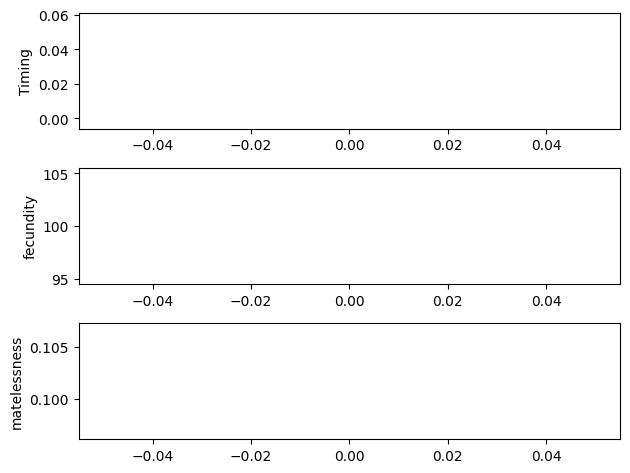

generation 0
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
100


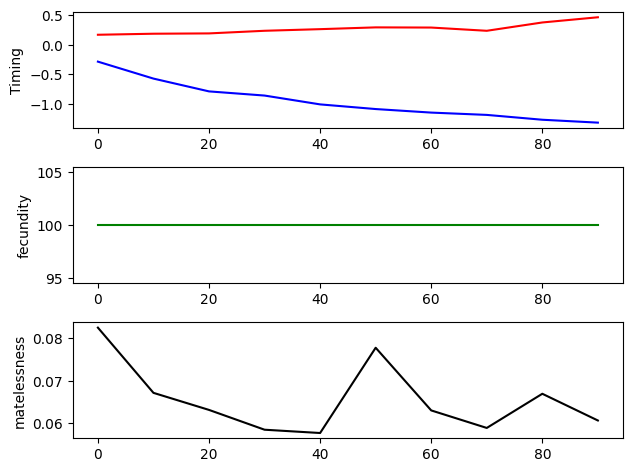

generation 100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
200


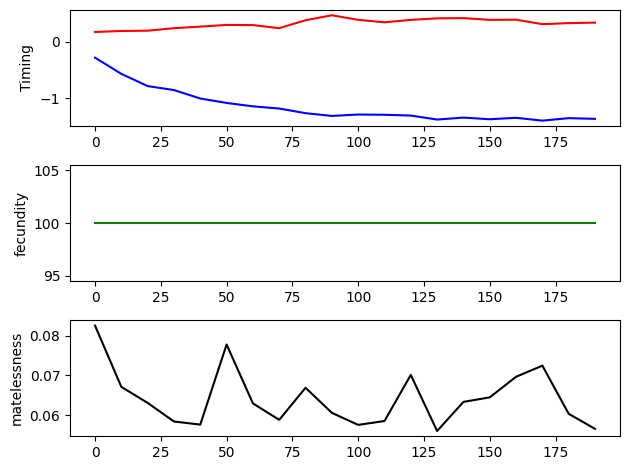

generation 200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
300


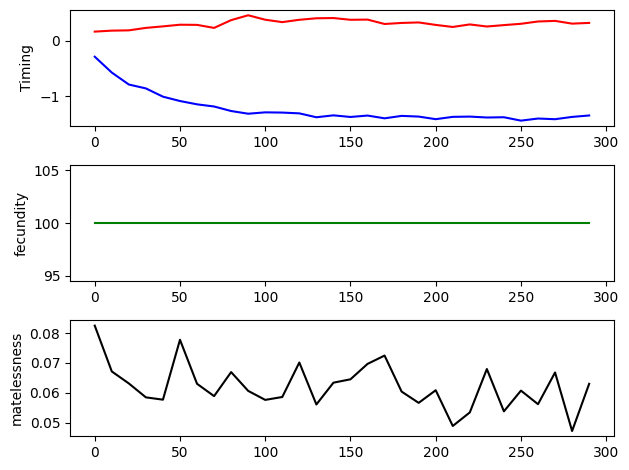

generation 300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
400


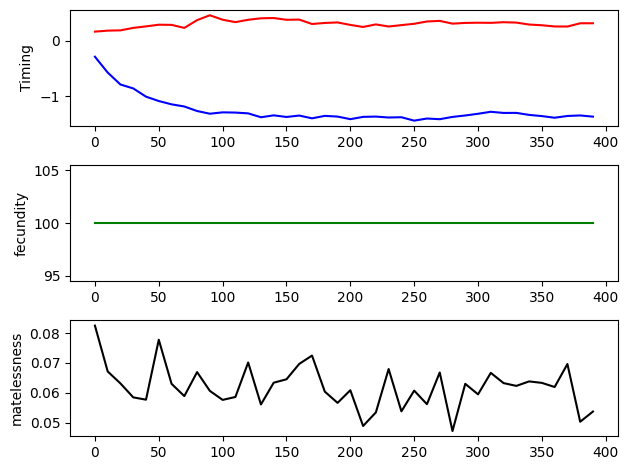

generation 400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
500


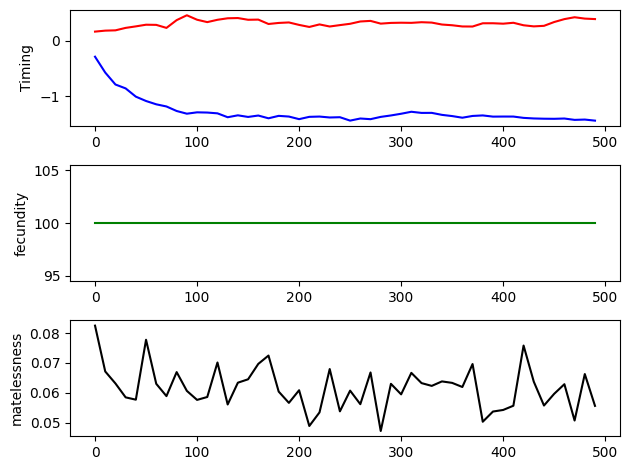

generation 500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
600


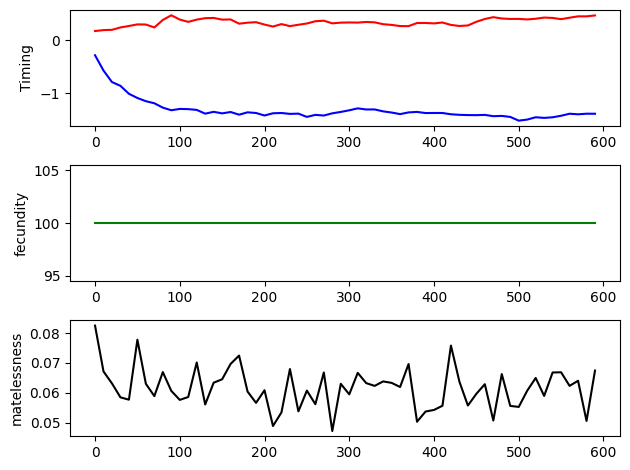

generation 600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
700


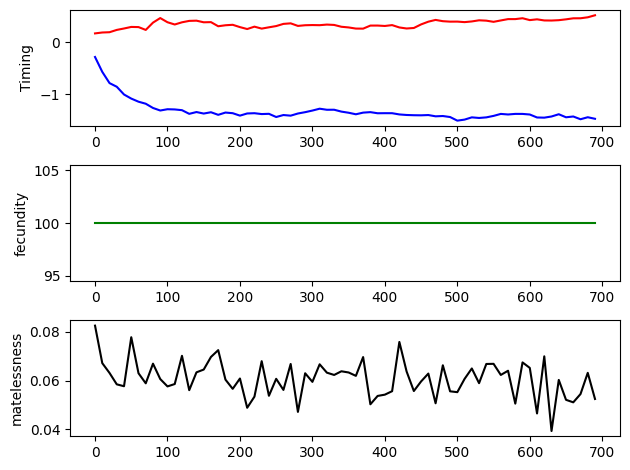

generation 700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
800


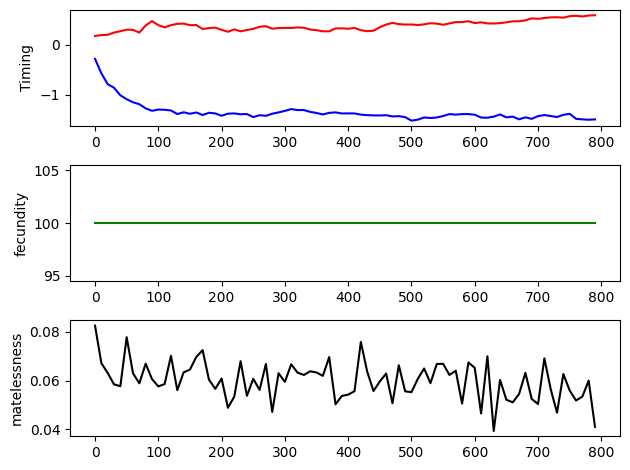

generation 800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
900


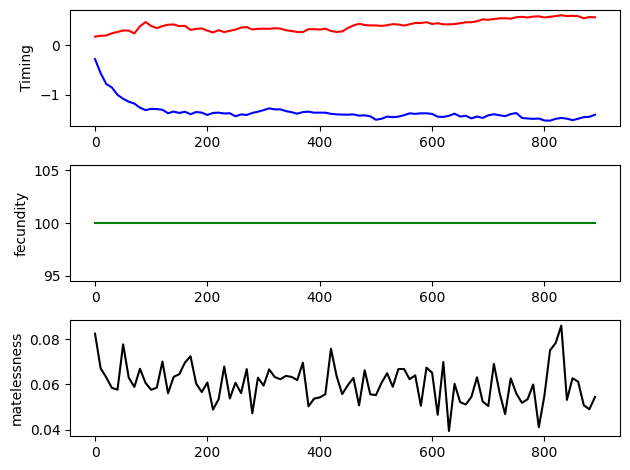

generation 900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1000


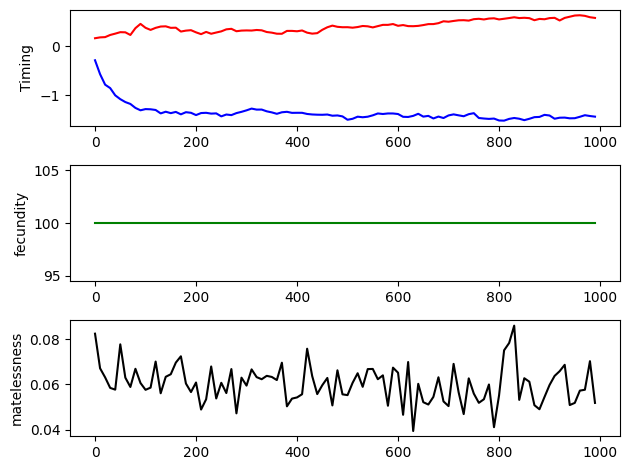

generation 1000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1100


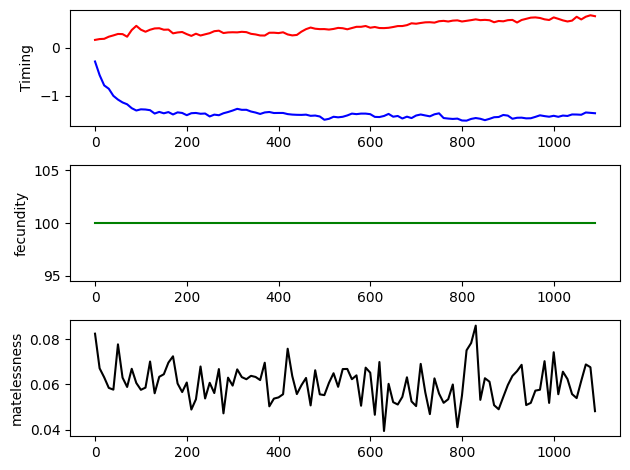

generation 1100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1200


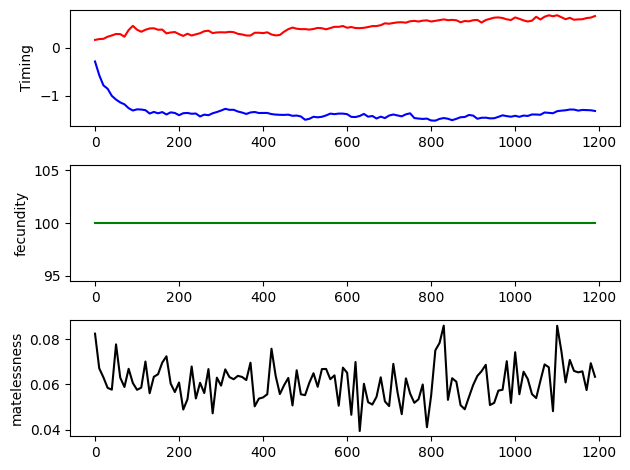

generation 1200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1300


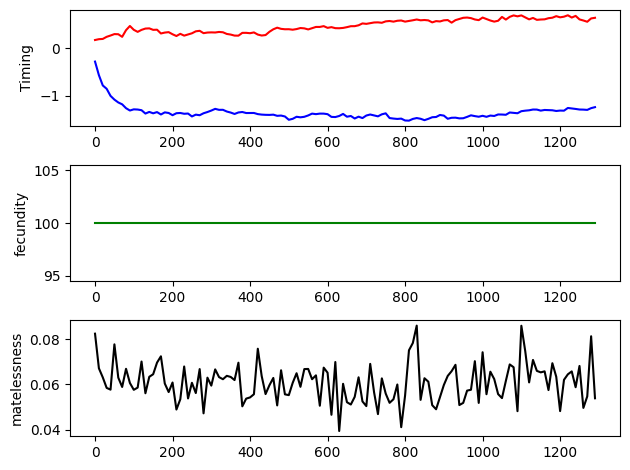

generation 1300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1400


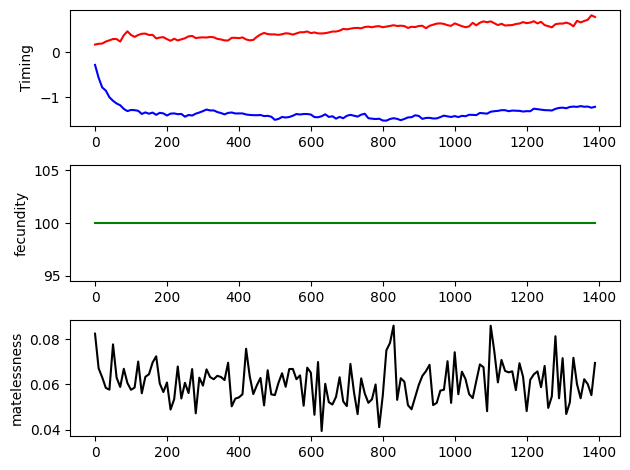

generation 1400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1500


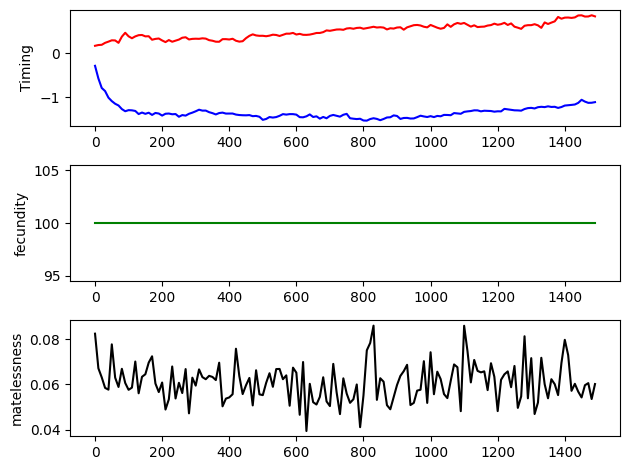

generation 1500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1600


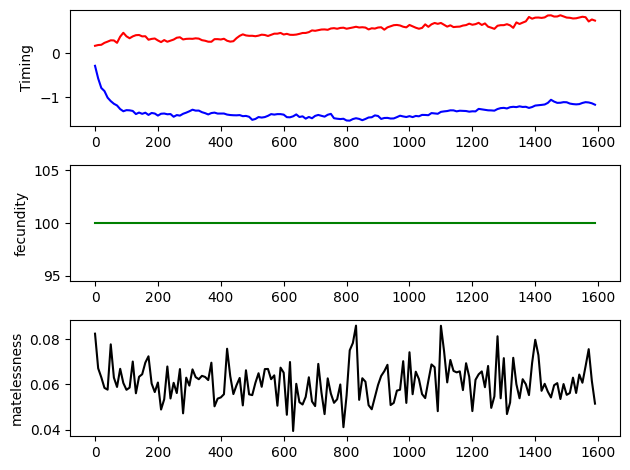

generation 1600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1700


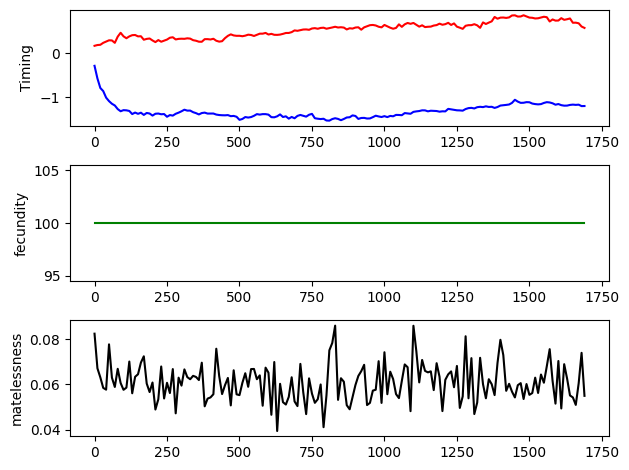

generation 1700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1800


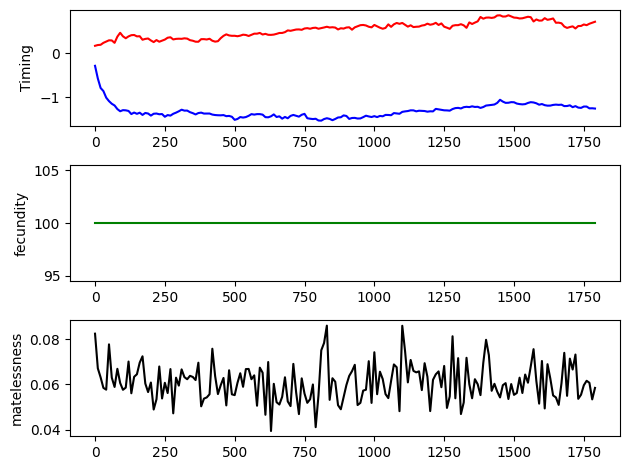

generation 1800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
1900


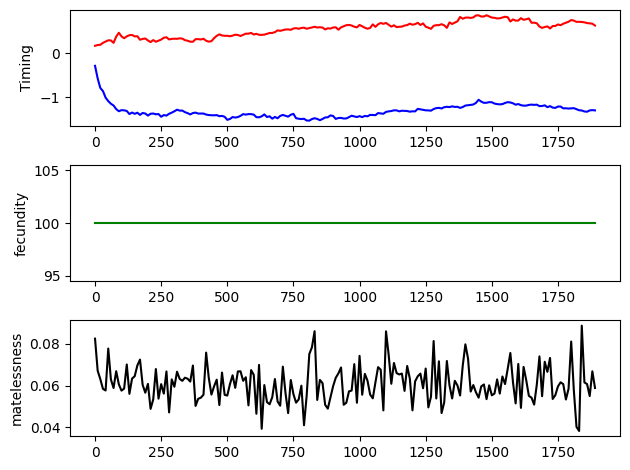

generation 1900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2000


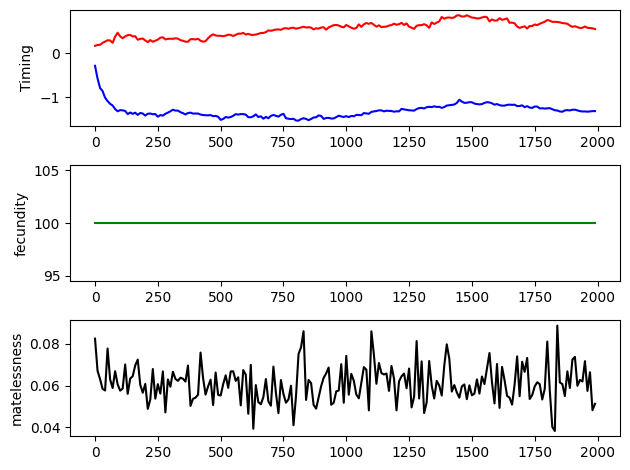

generation 2000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2100


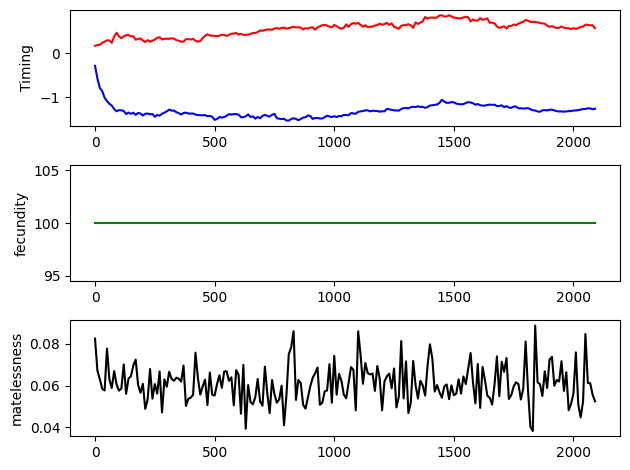

generation 2100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2200


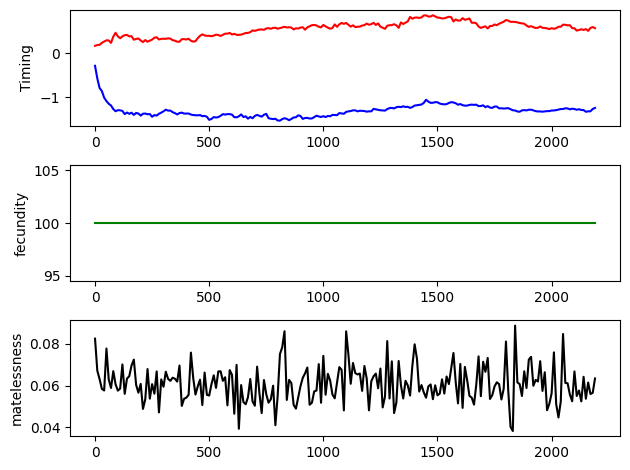

generation 2200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2300


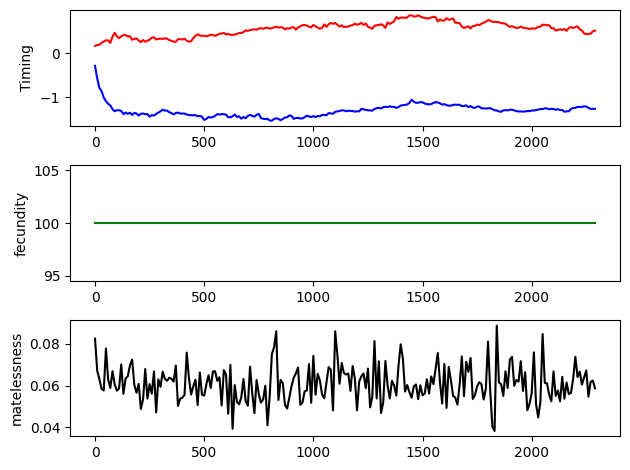

generation 2300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2400


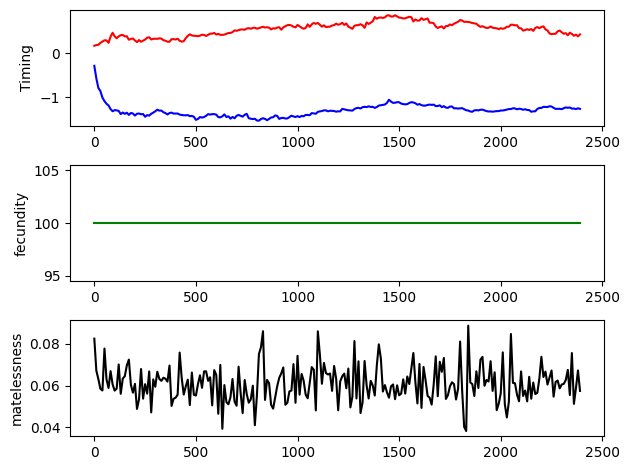

generation 2400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2500


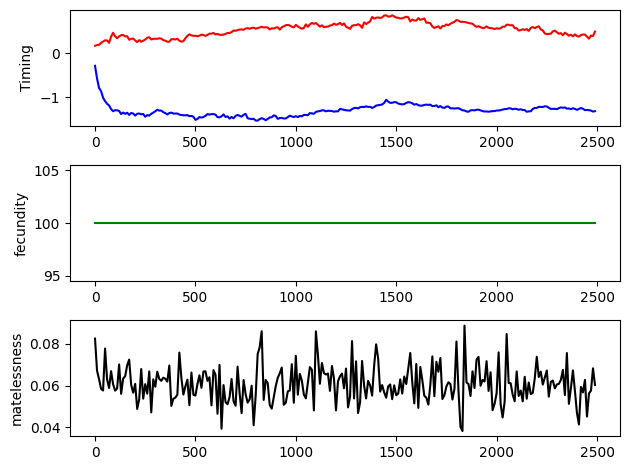

generation 2500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2600


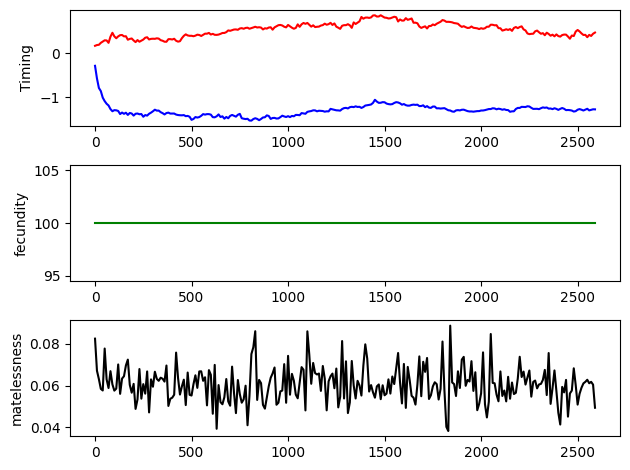

generation 2600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2700


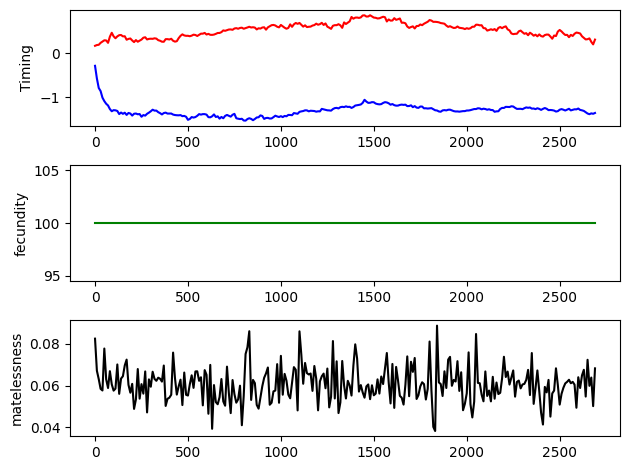

generation 2700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2800


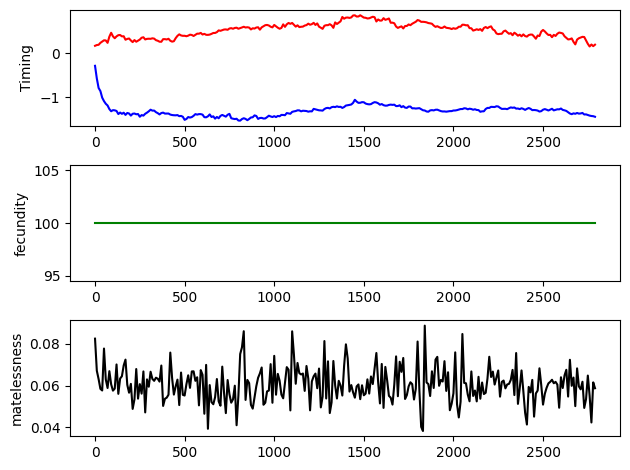

generation 2800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
2900


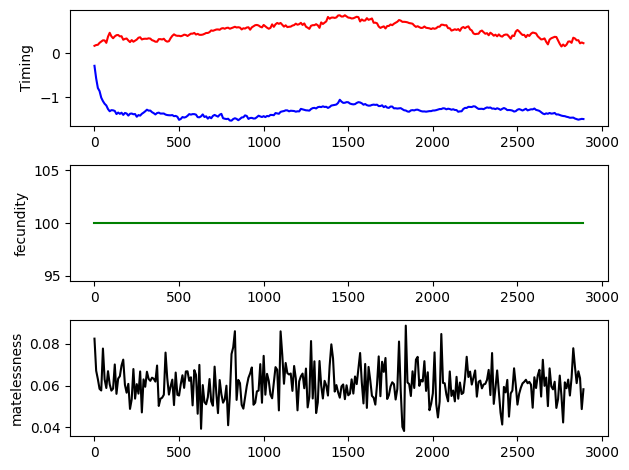

generation 2900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3000


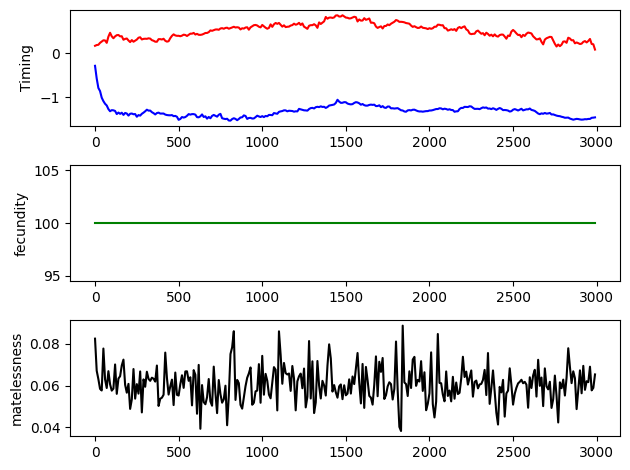

generation 3000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3100


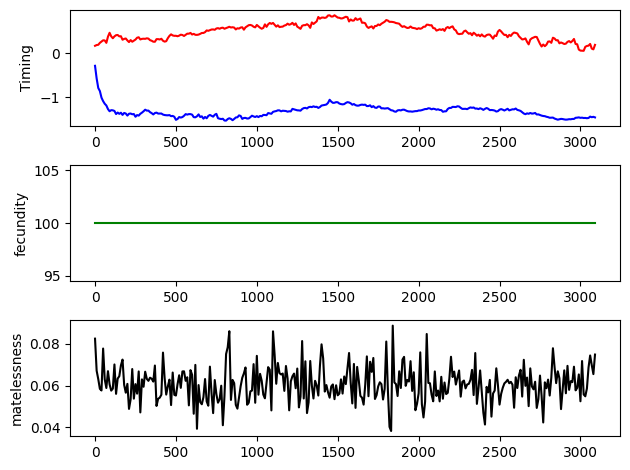

generation 3100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3200


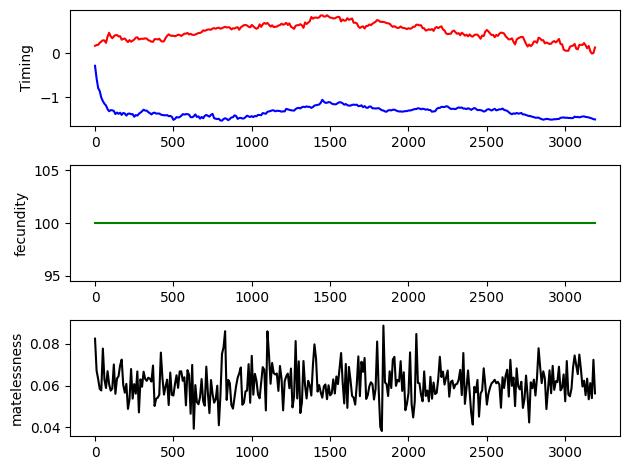

generation 3200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3300


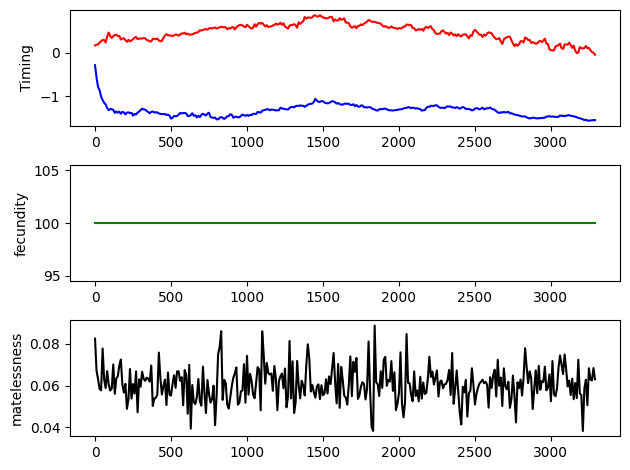

generation 3300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3400


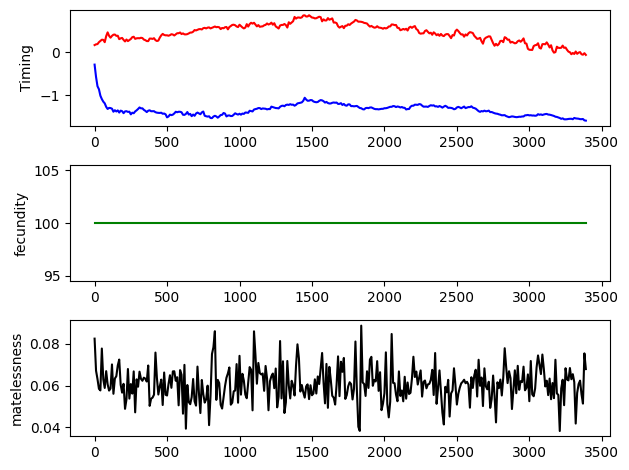

generation 3400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3500


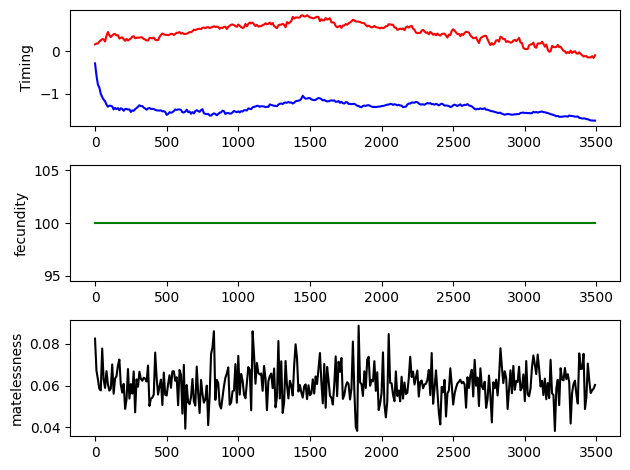

generation 3500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3600


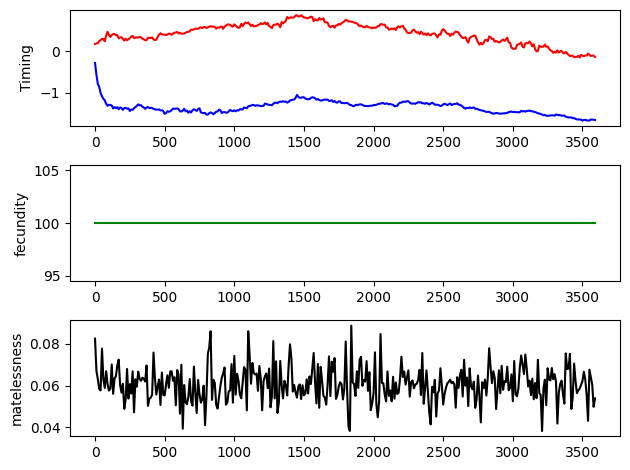

generation 3600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3700


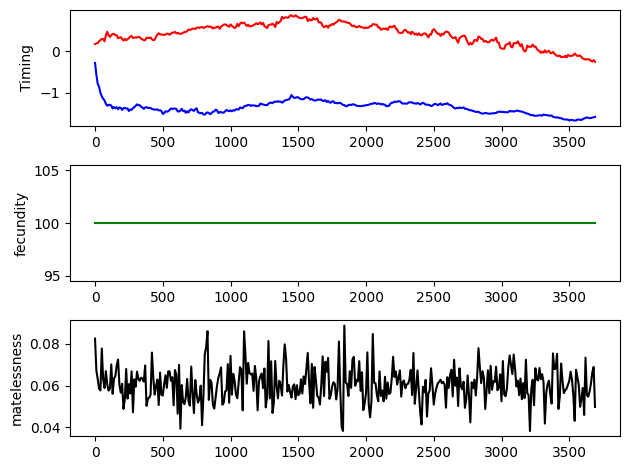

generation 3700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3800


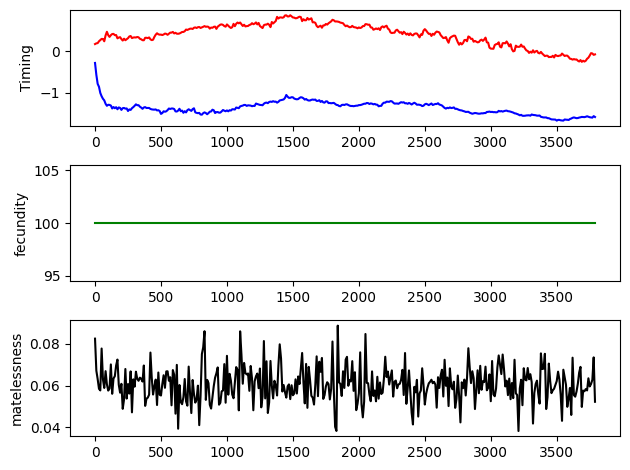

generation 3800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
3900


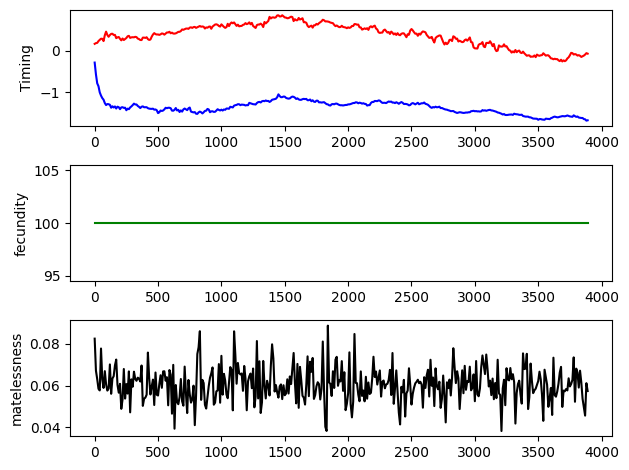

generation 3900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4000


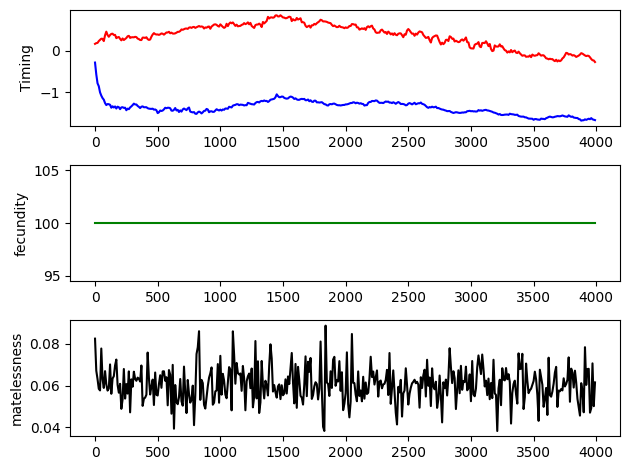

generation 4000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4100


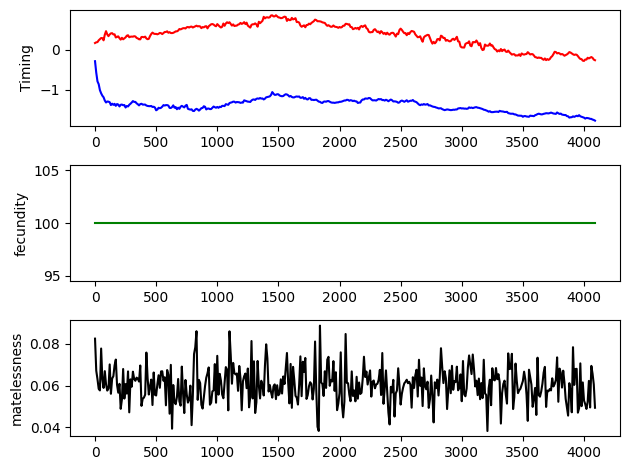

generation 4100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4200


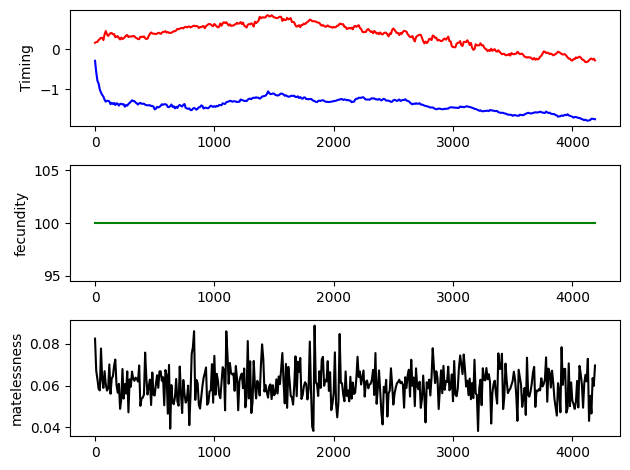

generation 4200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4300


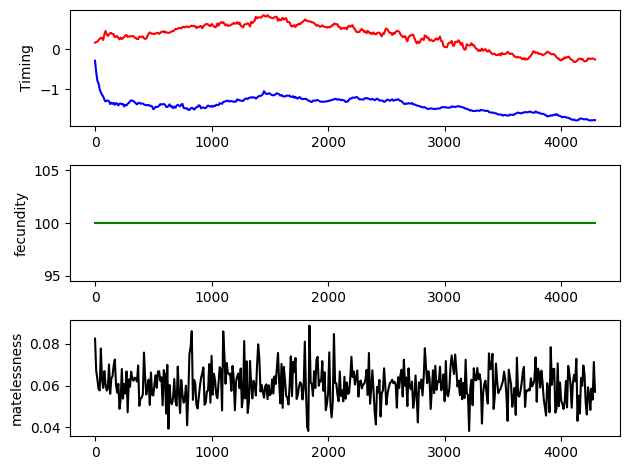

generation 4300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4400


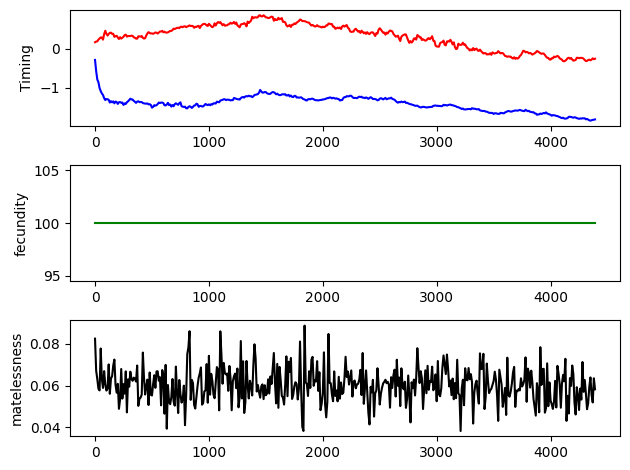

generation 4400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4500


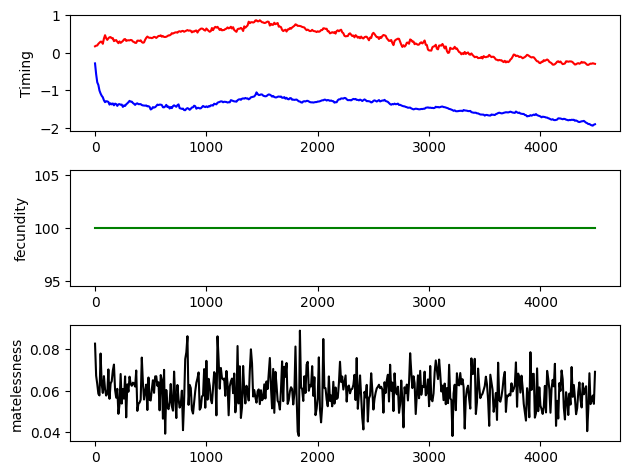

generation 4500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4600


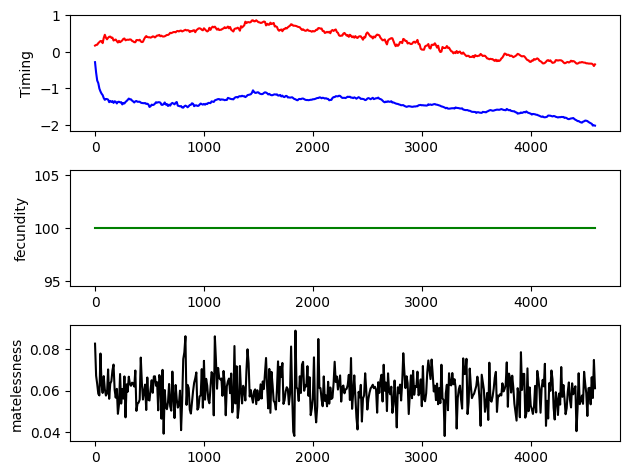

generation 4600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4700


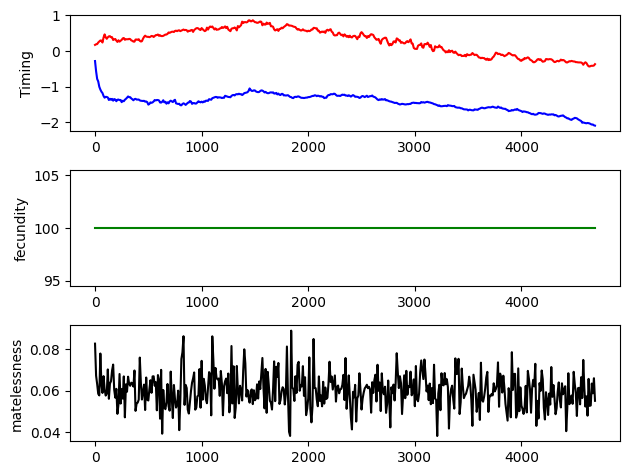

generation 4700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4800


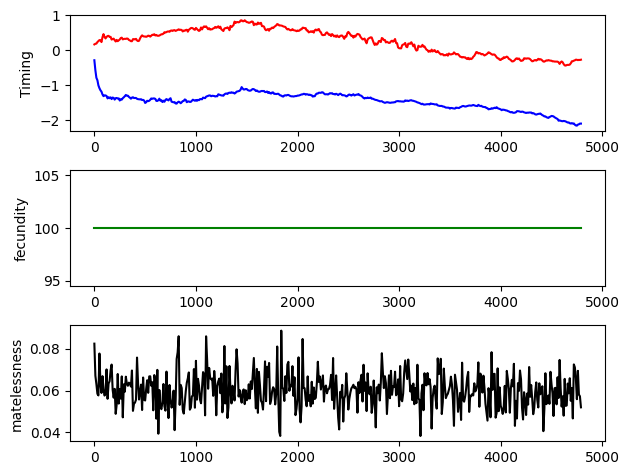

generation 4800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
4900


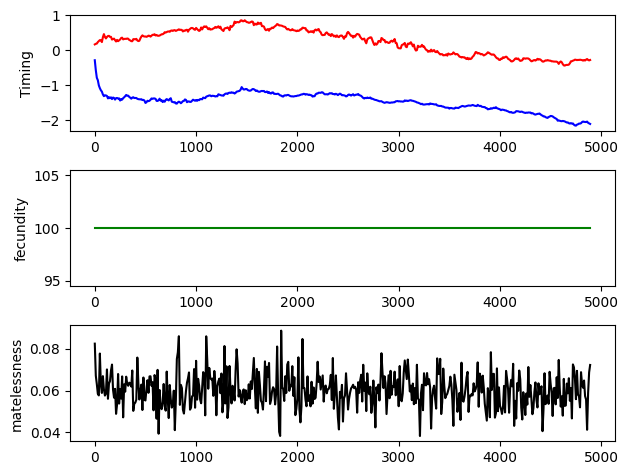

generation 4900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5000


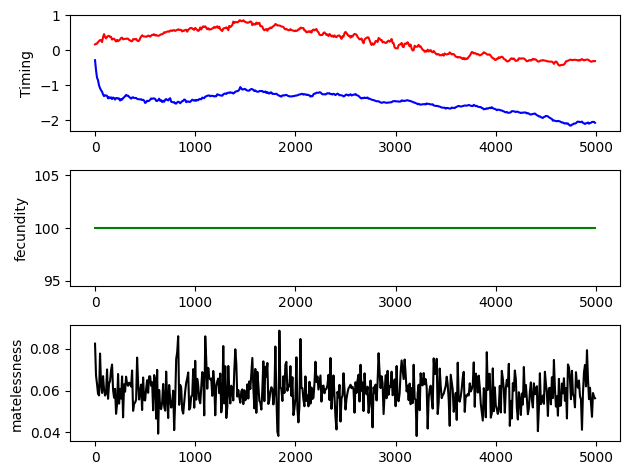

generation 5000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5100


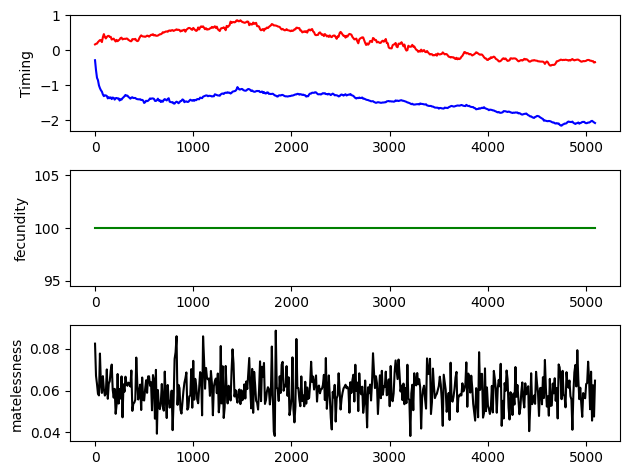

generation 5100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5200


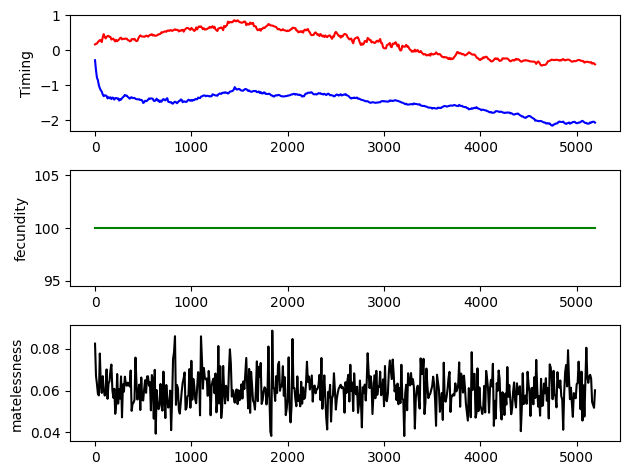

generation 5200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5300


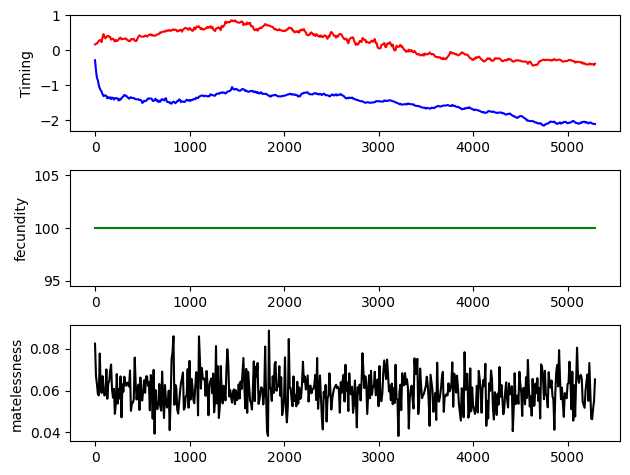

generation 5300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5400


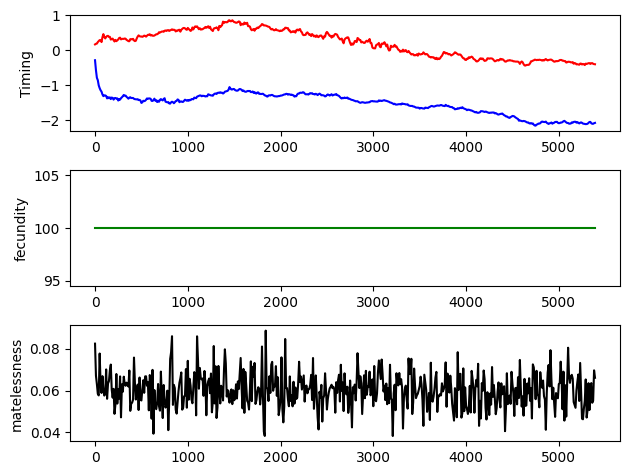

generation 5400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5500


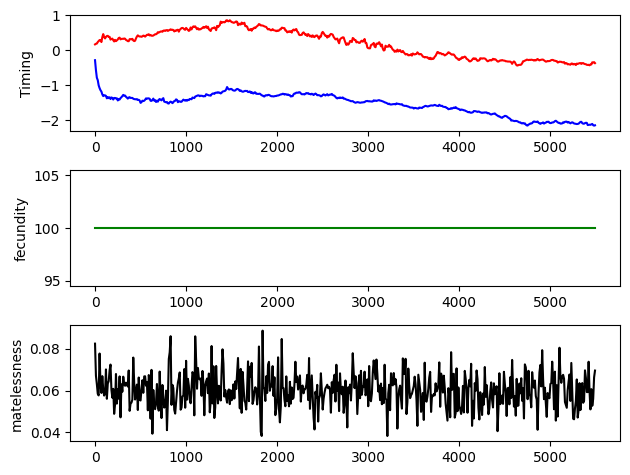

generation 5500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5600


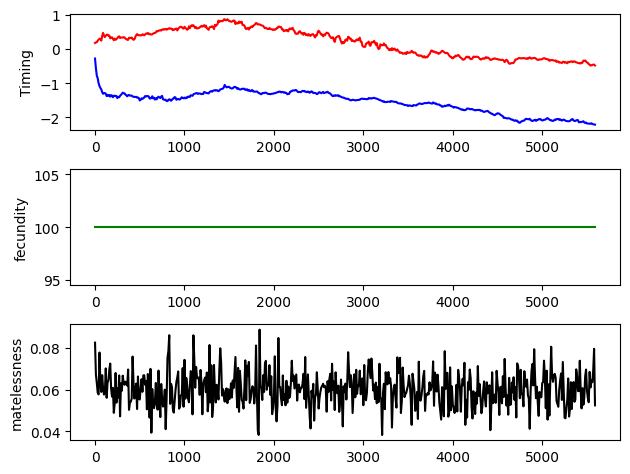

generation 5600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5700


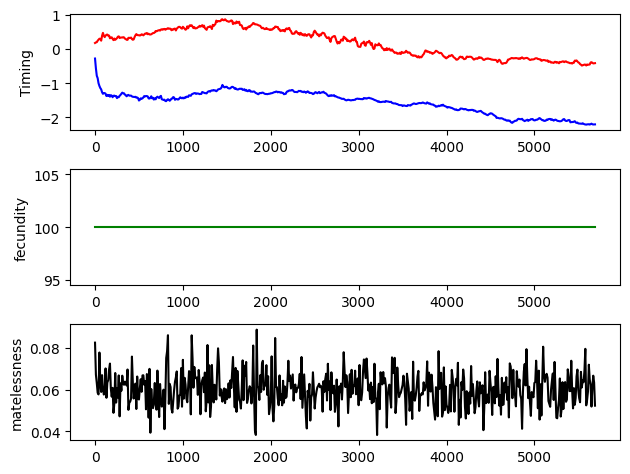

generation 5700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5800


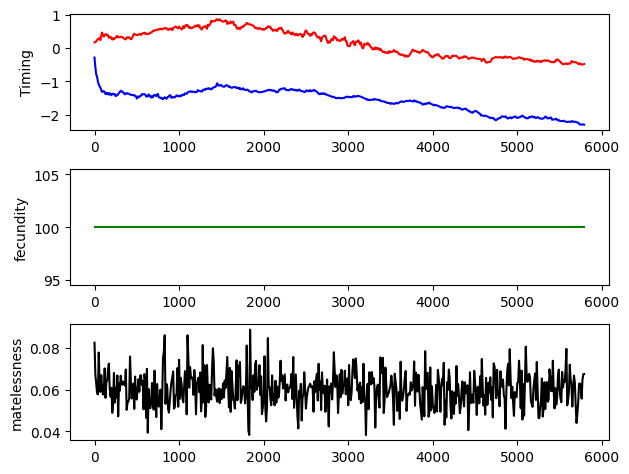

generation 5800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
5900


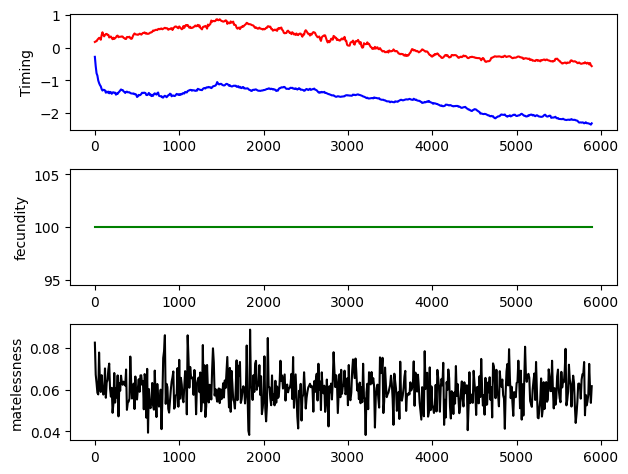

generation 5900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6000


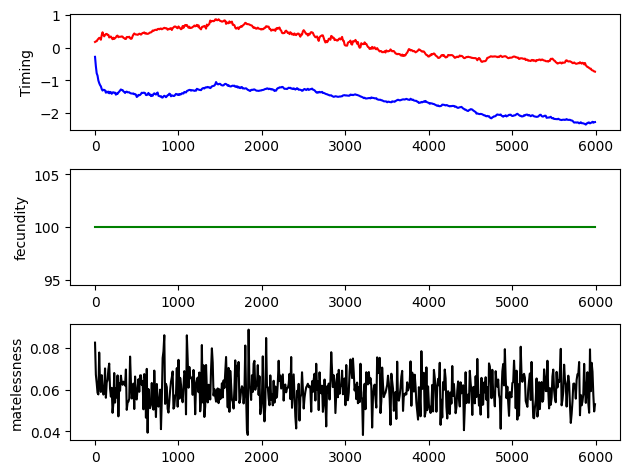

generation 6000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6100


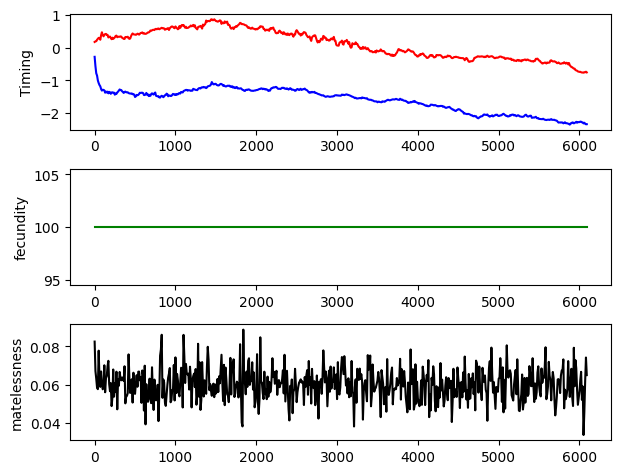

generation 6100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6200


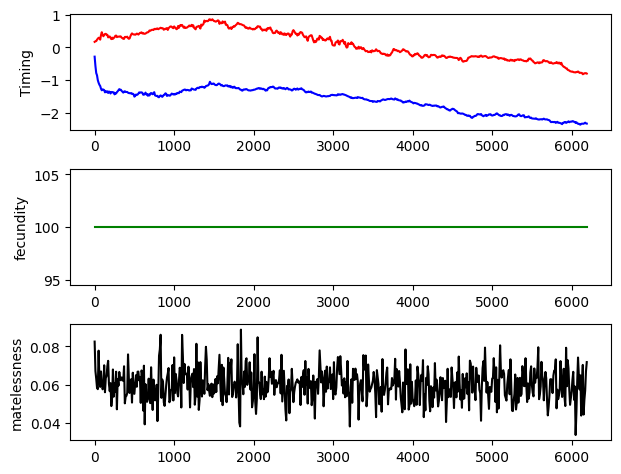

generation 6200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6300


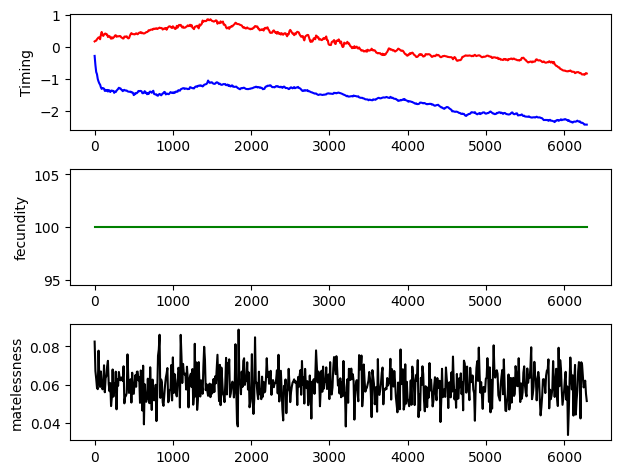

generation 6300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6400


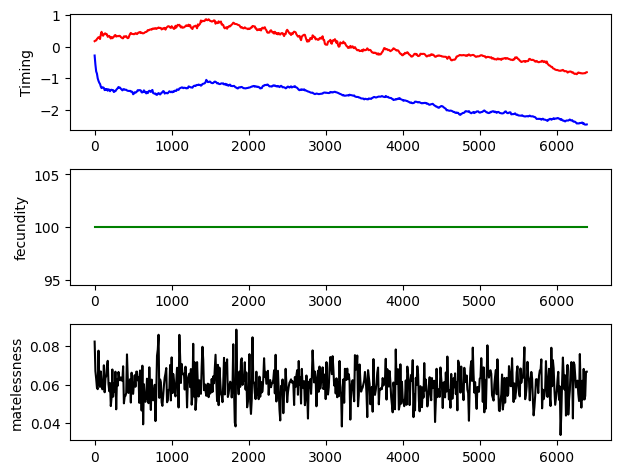

generation 6400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6500


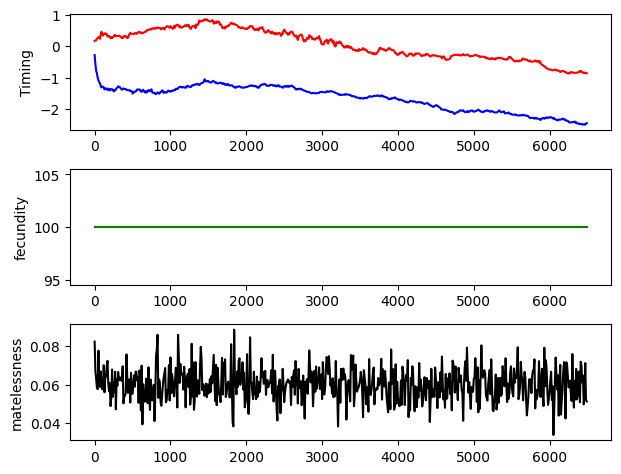

generation 6500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6600


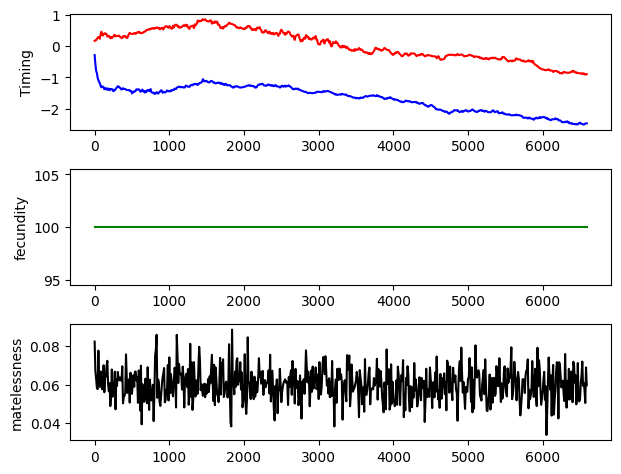

generation 6600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6700


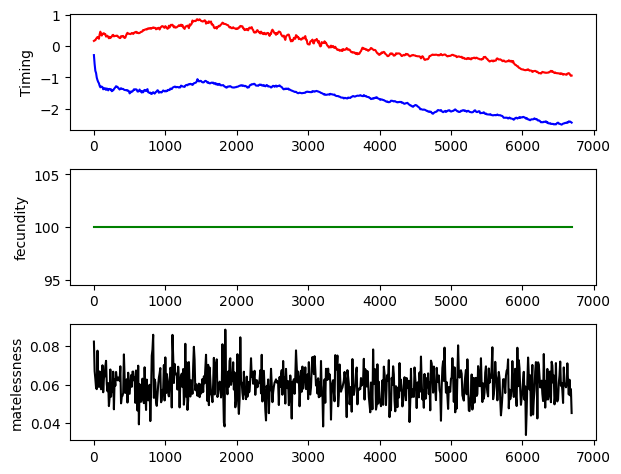

generation 6700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6800


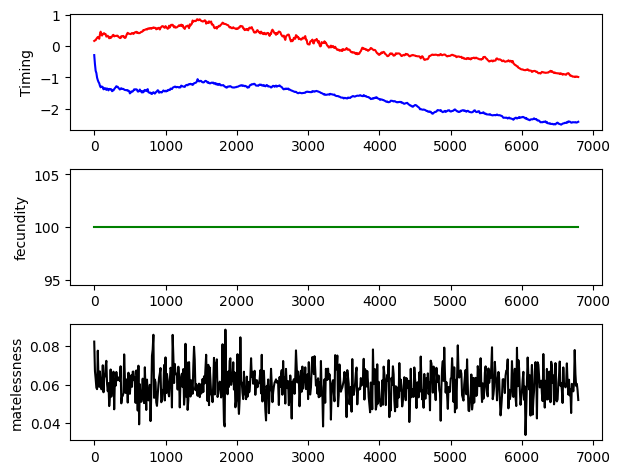

generation 6800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
6900


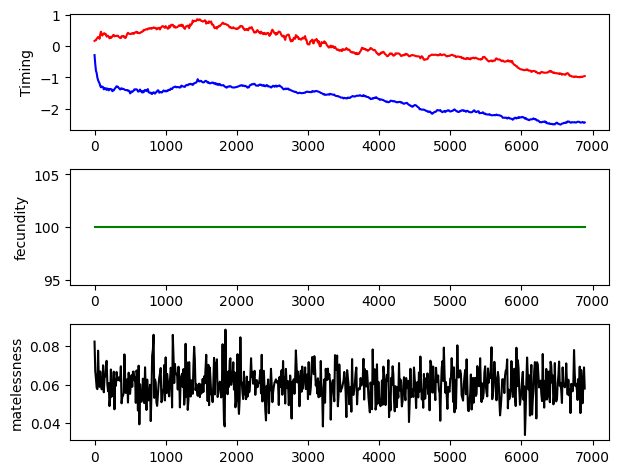

generation 6900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7000


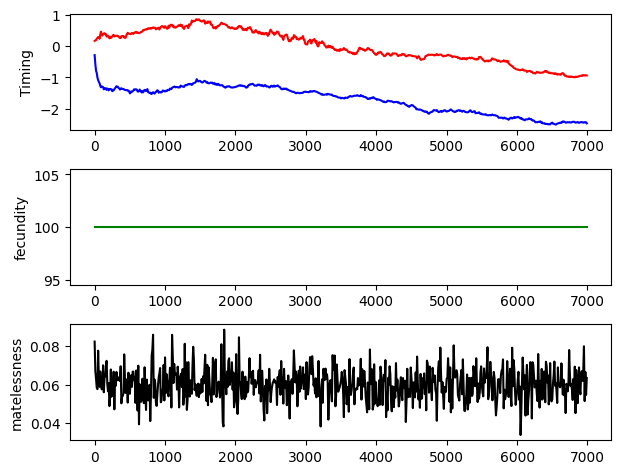

generation 7000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7100


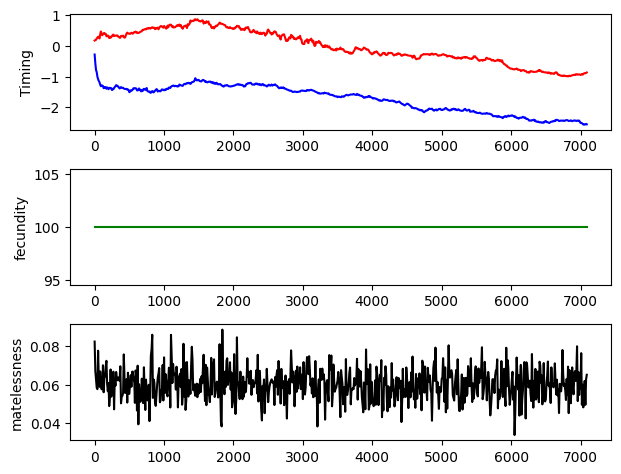

generation 7100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7200


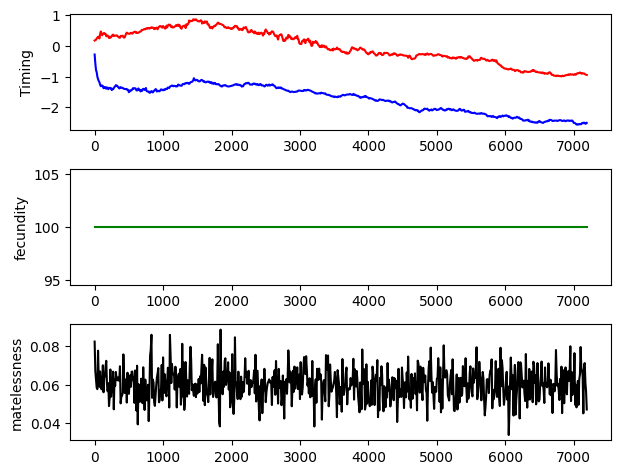

generation 7200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7300


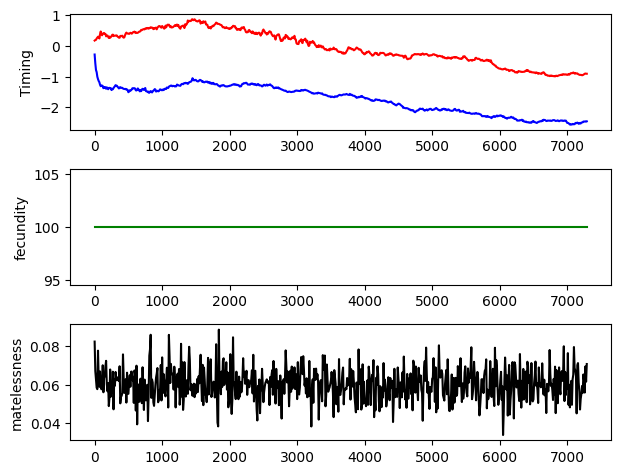

generation 7300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7400


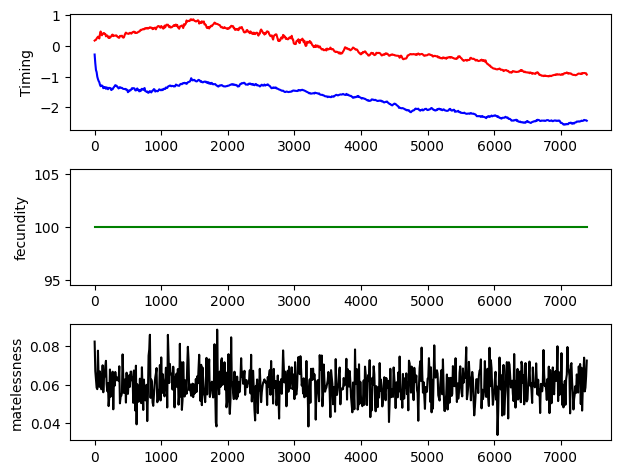

generation 7400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7500


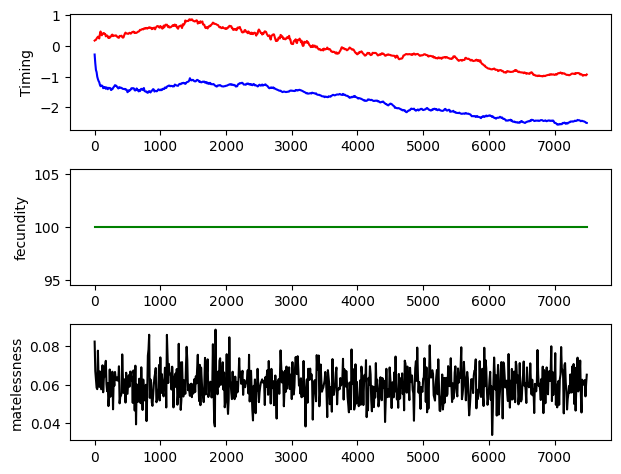

generation 7500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7600


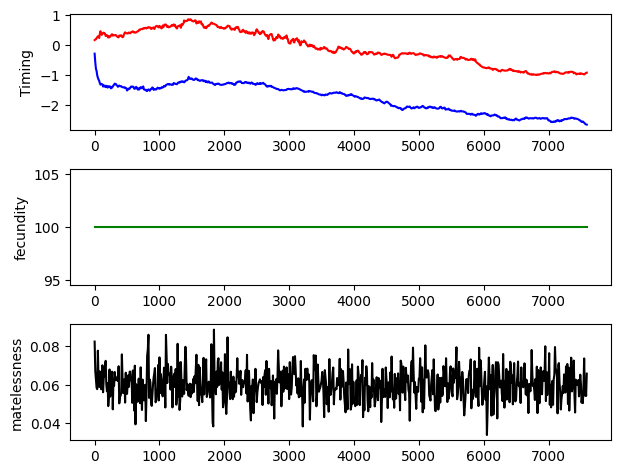

generation 7600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7700


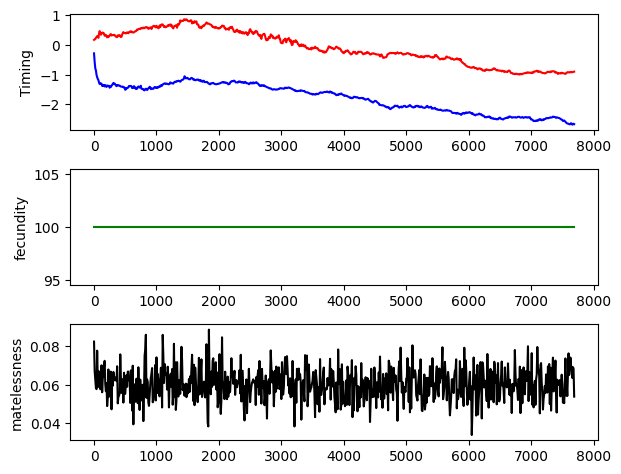

generation 7700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7800


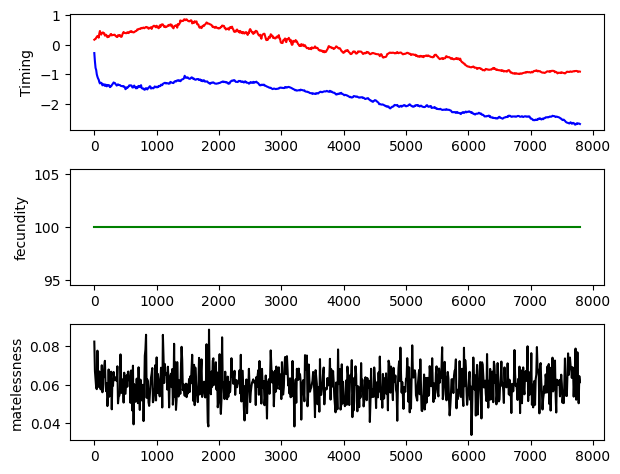

generation 7800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
7900


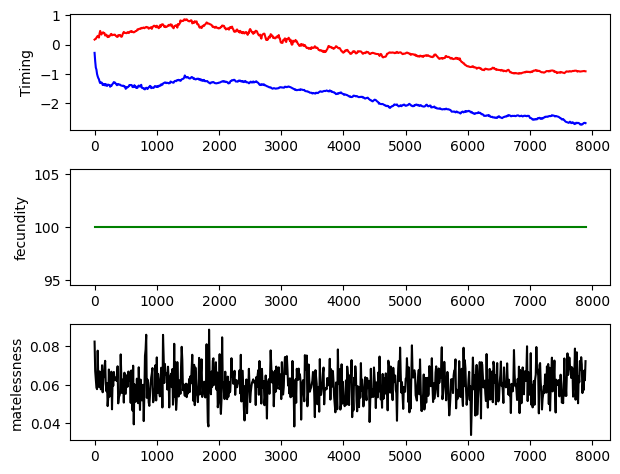

generation 7900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8000


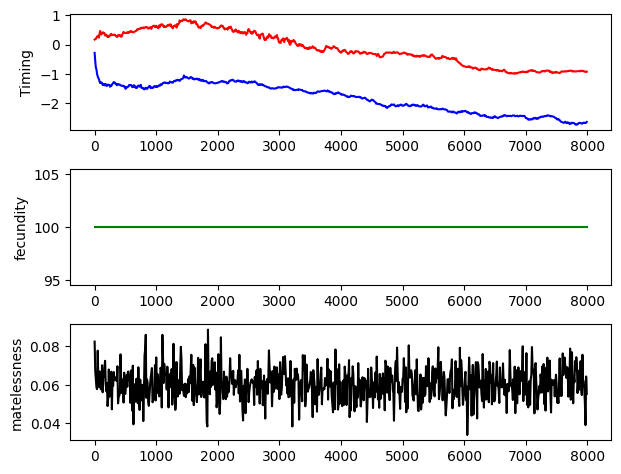

generation 8000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8100


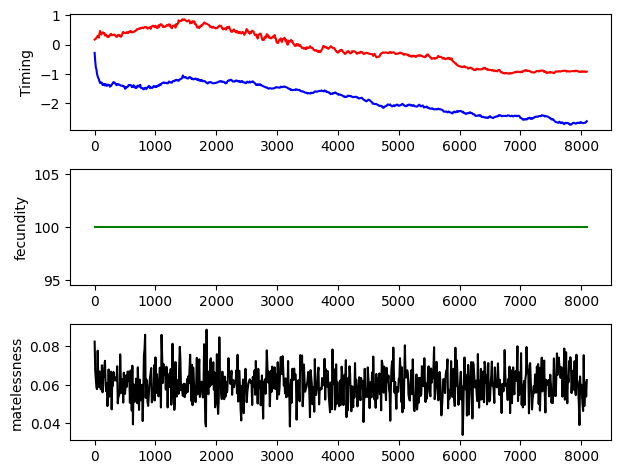

generation 8100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8200


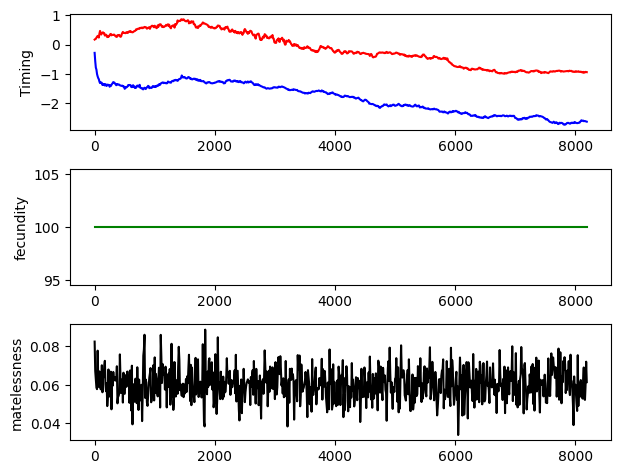

generation 8200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8300


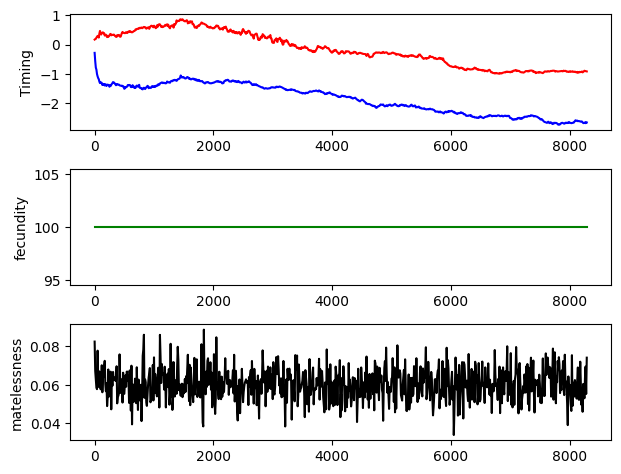

generation 8300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8400


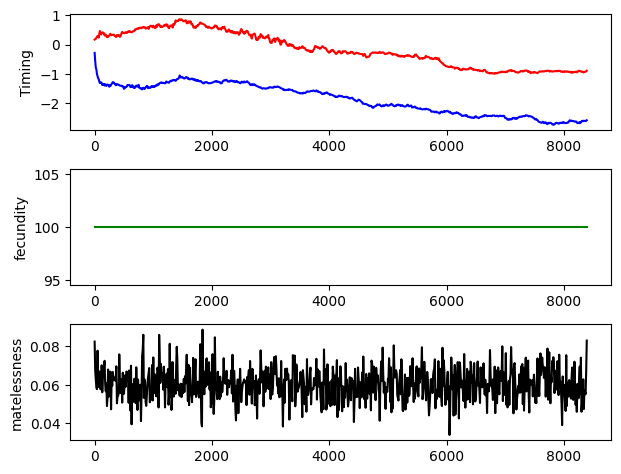

generation 8400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8500


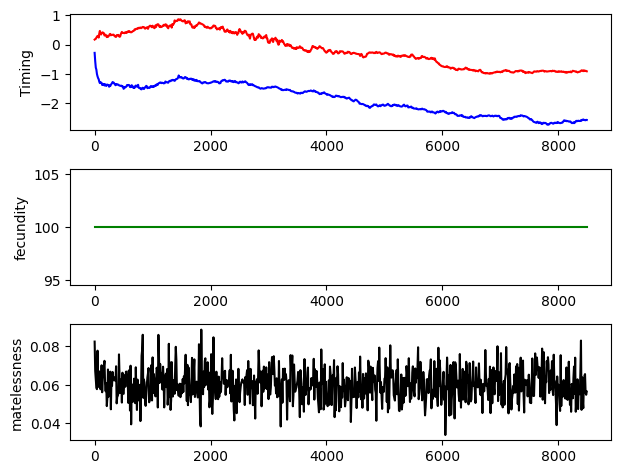

generation 8500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8600


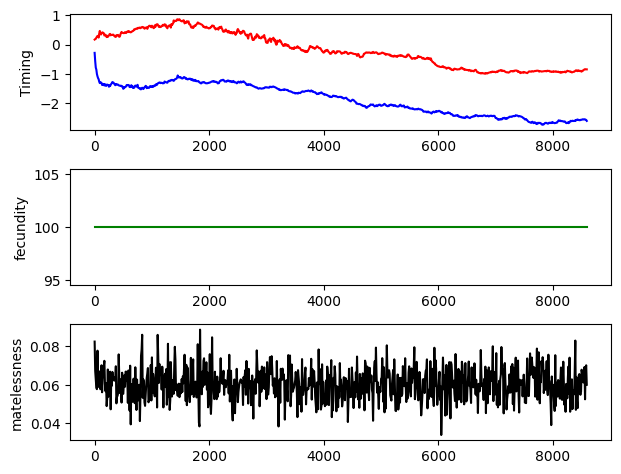

generation 8600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8700


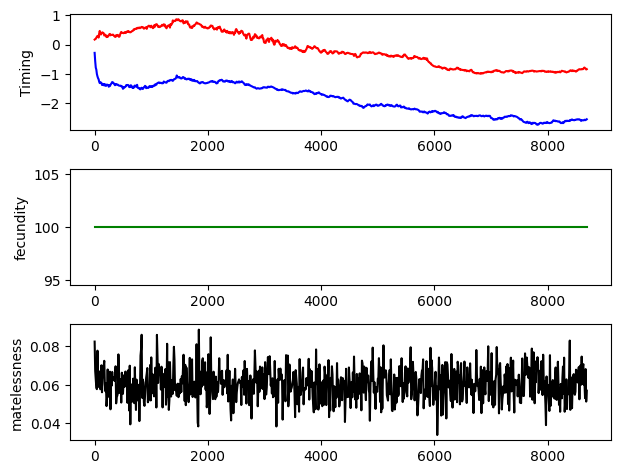

generation 8700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8800


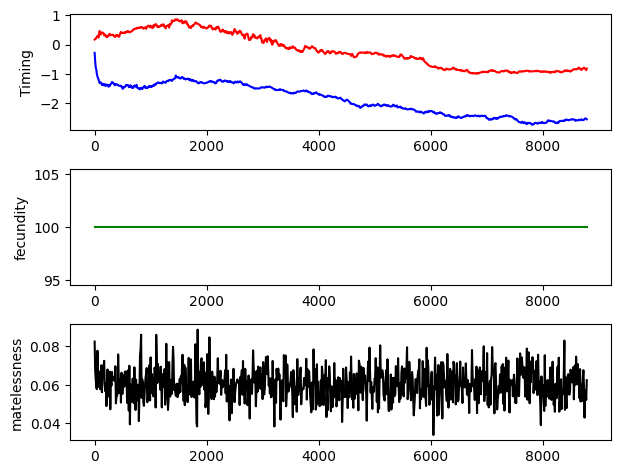

generation 8800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
8900


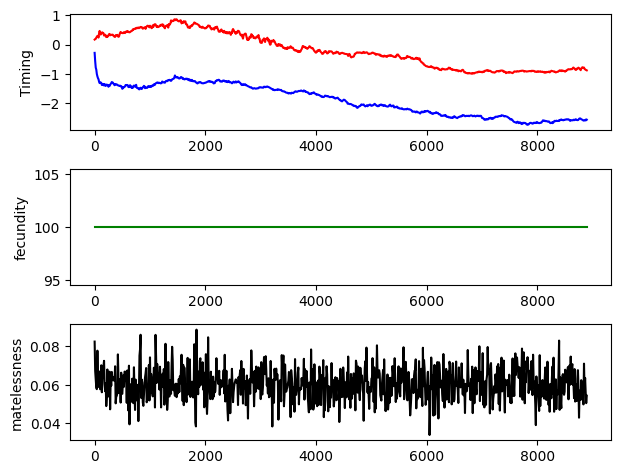

generation 8900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9000


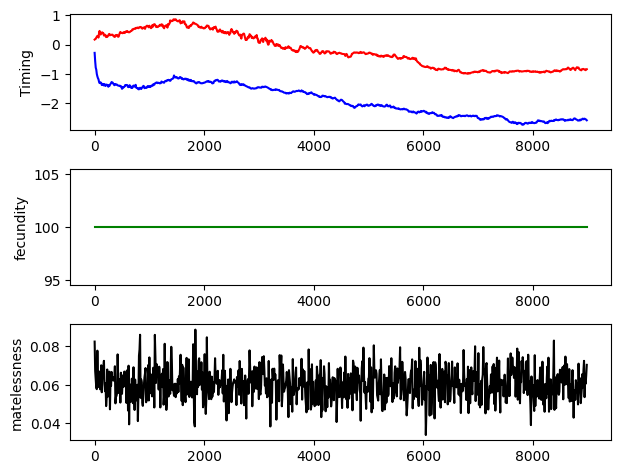

generation 9000
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9100


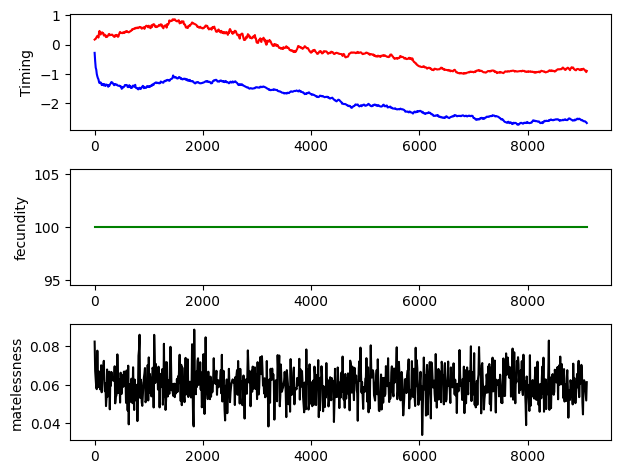

generation 9100
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9200


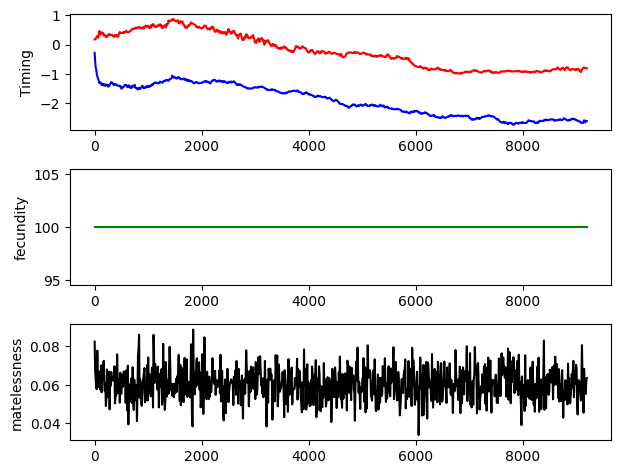

generation 9200
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9300


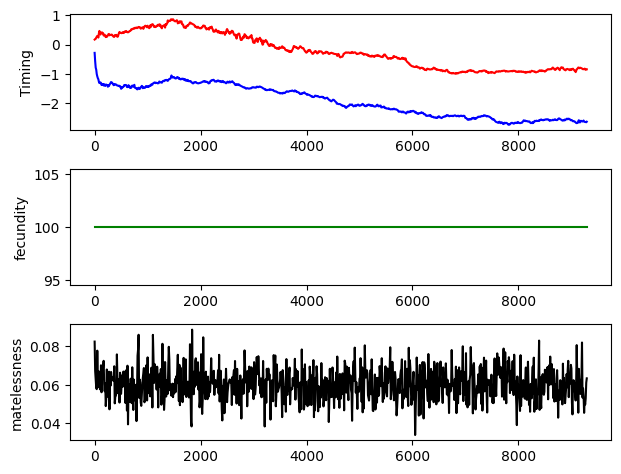

generation 9300
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9400


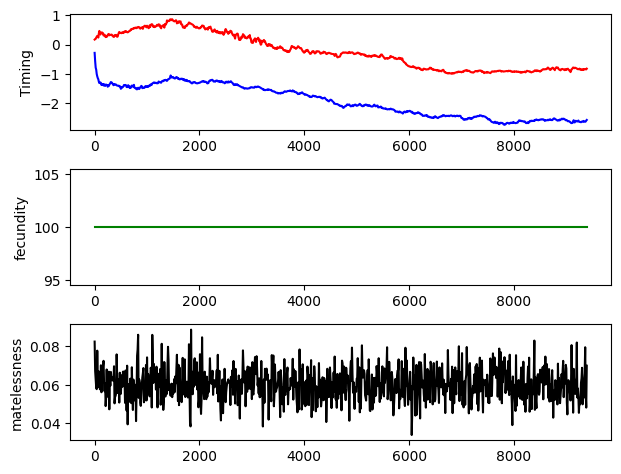

generation 9400
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9500


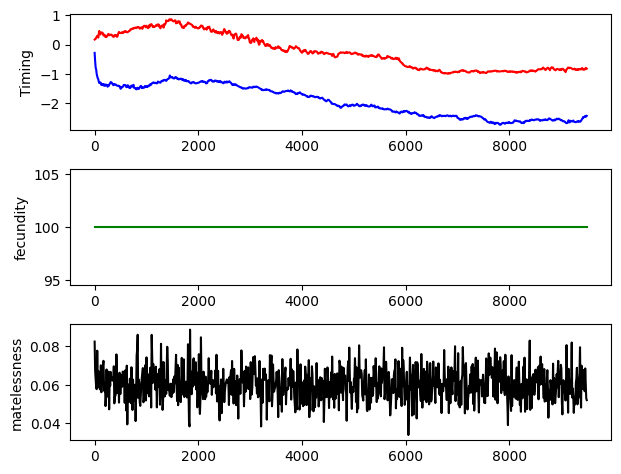

generation 9500
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9600


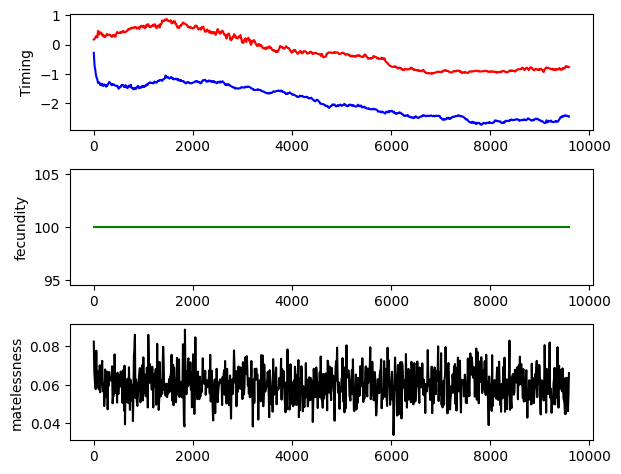

generation 9600
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9700


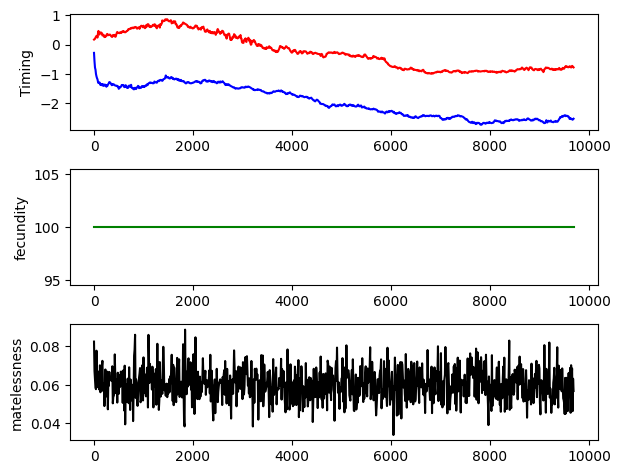

generation 9700
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9800


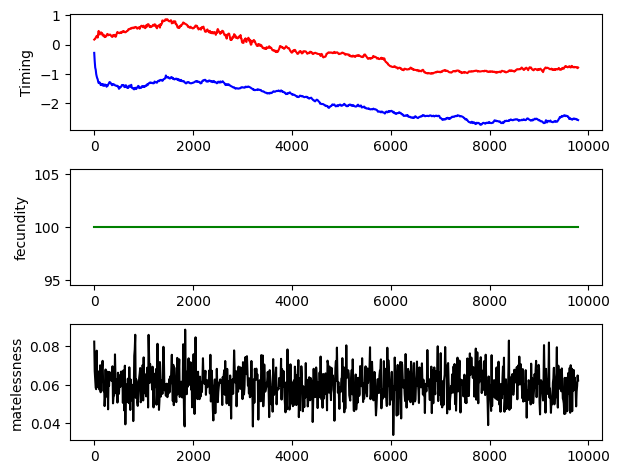

generation 9800
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]
 [     nan      nan      nan      nan]]
9900


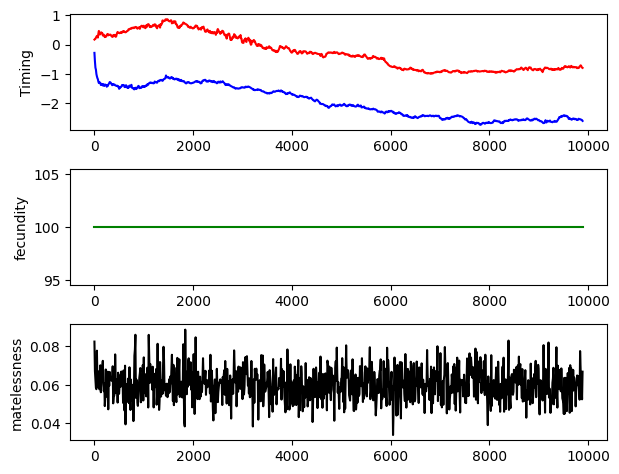

generation 9900
[[ -0.2843   0.1692 100.       0.0825]
 [ -0.5704   0.1867 100.       0.0671]
 [ -0.7864   0.1921 100.       0.0631]
 ...
 [ -2.6477  -0.7414 100.       0.0591]
 [ -2.6687  -0.7149 100.       0.0701]
 [     nan      nan      nan      nan]]
10000


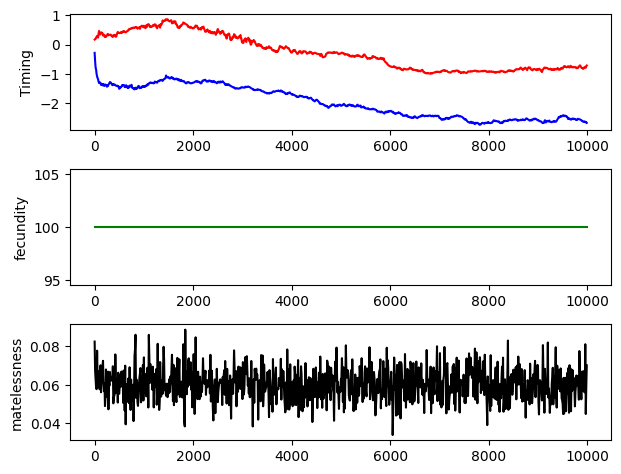

generation 10000


[sex: -1, alleles: -2.52,
 sex: -1, alleles: -2.57,
 sex: 1, alleles: -0.33,
 sex: -1, alleles: -2.77,
 sex: -1, alleles: -2.28,
 sex: -1, alleles: -2.28,
 sex: 1, alleles: -0.76,
 sex: -1, alleles: -2.64,
 sex: 1, alleles: -0.31,
 sex: 1, alleles: -0.01,
 sex: 1, alleles: -0.64,
 sex: -1, alleles: -2.58,
 sex: -1, alleles: -2.29,
 sex: 1, alleles: -0.38,
 sex: -1, alleles: -2.44,
 sex: -1, alleles: -2.84,
 sex: 1, alleles: -1.01,
 sex: 1, alleles: -0.98,
 sex: 1, alleles: -0.25,
 sex: 1, alleles: -0.41,
 sex: 1, alleles: -0.79,
 sex: 1, alleles: -0.55,
 sex: -1, alleles: -2.62,
 sex: -1, alleles: -3.03,
 sex: 1, alleles: -0.97,
 sex: -1, alleles: -2.71,
 sex: 1, alleles: -1.19,
 sex: 1, alleles: -0.48,
 sex: 1, alleles: -0.85,
 sex: -1, alleles: -2.56,
 sex: 1, alleles: -0.39,
 sex: 1, alleles: -0.57,
 sex: 1, alleles: -0.45,
 sex: 1, alleles: -1.1,
 sex: 1, alleles: -0.33,
 sex: -1, alleles: -2.49,
 sex: 1, alleles: -0.4,
 sex: -1, alleles: -2.81,
 sex: 1, alleles: -0.95,
 sex: 1, al

In [14]:
class simulation_over_generations():
    def __init__(self):
        self.parameters_instance = parameters()
        self.data_collection_and_plotting_instance = data_collection_and_plotting(self.parameters_instance)


    def run_simulation_for_over_generations(self):
        list_of_individuals = self.initialise_population()
        for generation_number in range(self.parameters_instance.generations):
            list_of_individuals_next_generation = one_generation_simulation(self.parameters_instance).run_simulation_for_one_generation(list_of_individuals)
            
            if generation_number % 10 == 0:
                self.data_collection_and_plotting_instance.data_collection_function(list_of_individuals, generation_number)
                if generation_number % 100 == 0:
                    print(self.data_collection_and_plotting_instance.data)
                    print(generation_number)
                    self.data_collection_and_plotting_instance.plot_data(generation_number)
            list_of_individuals = list_of_individuals_next_generation

        return list_of_individuals

    def initialise_population(self):
        initial_list_of_individuals = []
        for i in range(self.parameters_instance.popsize):
            individual_instance = Individual(self.parameters_instance)
            individual_instance.index = i
            individual_instance.initialise_alleles_emergence_and_deathtime()
            initial_list_of_individuals.append(individual_instance)
        return initial_list_of_individuals

    
    

parameters_instance = parameters()
simulation_insatnce = simulation_over_generations()
simulation_insatnce.run_simulation_for_over_generations()